# Instalación del paquetes

In [77]:
pip install dill

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [60]:
pip install ucimlrepo pandas numpy seaborn matplotlib scipy scikit-learn imbalanced-learn lightgbm optuna xgboost Jinja2 catboost umap-learn


   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 1.5 MB/s eta 0:00:02
   ----------- ---------------------------- 0.8/2.8 MB 1.5 MB/s eta 0:00:02
   -------------- ------------------------- 1.0/2.8 MB 1.4 MB/s eta 0:00:02
   ------------------ --------------------- 1.3/2.8 MB 1.3 MB/s eta 0:00:02
   ---------------------- ----------------- 1.6/2.8 MB 1.2 MB/s eta 0:00:02
   ---------------------- ----------------- 1.6/2.8 MB 1.2 MB/s eta 0:00:02
   ------------------------- -------------- 1.8/2.8 MB 1.1 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 1.1 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 1.1 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 1.1 MB/s eta 0:00:01
   ----------------------------- ---------- 2.1/2.8 MB 815.6 kB/s eta 0:00:01
   ---------------------

In [63]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


# Importación de librerías

In [78]:
from ucimlrepo import fetch_ucirepo

import pandas as pd
#from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest, anderson, chi2_contingency, spearmanr, kruskal, mannwhitneyu
from sklearn.feature_selection import mutual_info_classif
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, classification_report

from scipy.stats import friedmanchisquare, wilcoxon
import itertools
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectFromModel
import umap.umap_ as umap
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
import optuna
from xgboost import XGBClassifier
import math
import time
from catboost import CatBoostClassifier

In [87]:
import pickle

# Crear un diccionario solo con las variables que necesitas
mis_variables = {
    "metrics_lr_opt_ov": metrics_lr_opt_ov,
    "metrics_lr_opt_un": metrics_lr_opt_un,
    "metrics_lr_opt_wght": metrics_lr_opt_wght,
    "metrics_lr_randcv_ov": metrics_lr_randcv_ov,
    "metrics_lr_randcv_un": metrics_lr_randcv_un,
    "metrics_lr_randcv_wght": metrics_lr_randcv_wght,
    "metrics_lr_randcv_un_ov": metrics_lr_randcv_un_ov,
    "metrics_lr_randcv_un_ov_wght": metrics_lr_randcv_un_ov_wght,
    "metrics_lr_all": metrics_lr_all,
    "metrics_lr_final": metrics_lr_final
}

with open("mis_variables.pkl", "wb") as f:
    pickle.dump(mis_variables, f)


In [ ]:
import dill

# Carga la sesión desde el archivo 'session.pkl'
dill.load_session('mis_variables.pkl')

# Dataset

In [3]:
# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
Y = cdc_diabetes_health_indicators.data.targets
data = pd.concat([X, Y], axis=1)

data.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


In [4]:
# metadata
#print(cdc_diabetes_health_indicators.metadata)

# informacion de variables
variables_df = pd.DataFrame(cdc_diabetes_health_indicators.variables)
pd.set_option("display.max_colwidth", None)
display(variables_df[['name', 'description']].style.set_properties(**{'text-align': 'left'}))

# variables
numerical_columns = ['BMI', 'MentHlth', 'PhysHlth']
categorical_columns = X.drop(columns=numerical_columns).columns.tolist()
categorical_nonbinary_columns = ['GenHlth','Age', 'Education', 'Income']
categorical_binary_columns = [col for col in categorical_columns if col not in categorical_nonbinary_columns]

print("numerical_columns:", numerical_columns)
print("categorical_columns:", categorical_columns)
print("categorical_nonbinary_columns:", categorical_binary_columns)
print("categorical_binary_columns:", categorical_nonbinary_columns)

,name,description
0,ID,Patient ID
1,Diabetes_binary,0 = no diabetes 1 = prediabetes or diabetes
2,HighBP,0 = no high BP 1 = high BP
3,HighChol,0 = no high cholesterol 1 = high cholesterol
4,CholCheck,0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years
5,BMI,Body Mass Index
6,Smoker,Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes
7,Stroke,(Ever told) you had a stroke. 0 = no 1 = yes
8,HeartDiseaseorAttack,coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes
9,PhysActivity,physical activity in past 30 days - not including job 0 = no 1 = yes


numerical_columns: ['BMI', 'MentHlth', 'PhysHlth']
categorical_columns: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
categorical_nonbinary_columns: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
categorical_binary_columns: ['GenHlth', 'Age', 'Education', 'Income']


# 1. Exploración de los datos

## 1.1. ProfileReport

In [ ]:
report = ProfileReport(data)
report

NameError: name 'ProfileReport' is not defined

Observaciones:
* ninguna de las variables tienen valores faltantes
* en principio son todo numeros (se comprobará más adelante)
* se comprueba que los valores introducido efectivamente son los que se esperaban (no hay valores incorrectos)
* a simple vista no se observan outlayers muy significativos (se comprobará más adelante)
* existen imbalances en los datos en: CholCheck (77.0%), Stroke (75.5%), HeartDiseaseorAttack (55.0%), HvyAlcoholConsump (68.8%), AnyHealthcare (71.8%) y NoDocbcCost (58.3%).
* el Dataset tiene 11369 (4.5%) filas iguales (duplicadas?) => NO van a eliminarse, ya que Machine Learning Repository afirma lo siguiente: "Each row represents a person participating in this study."

## 1.2. Distribución de las características

### Tipo de distribución
Se analiza si las variables numéricas siguen o no una distribución normal.

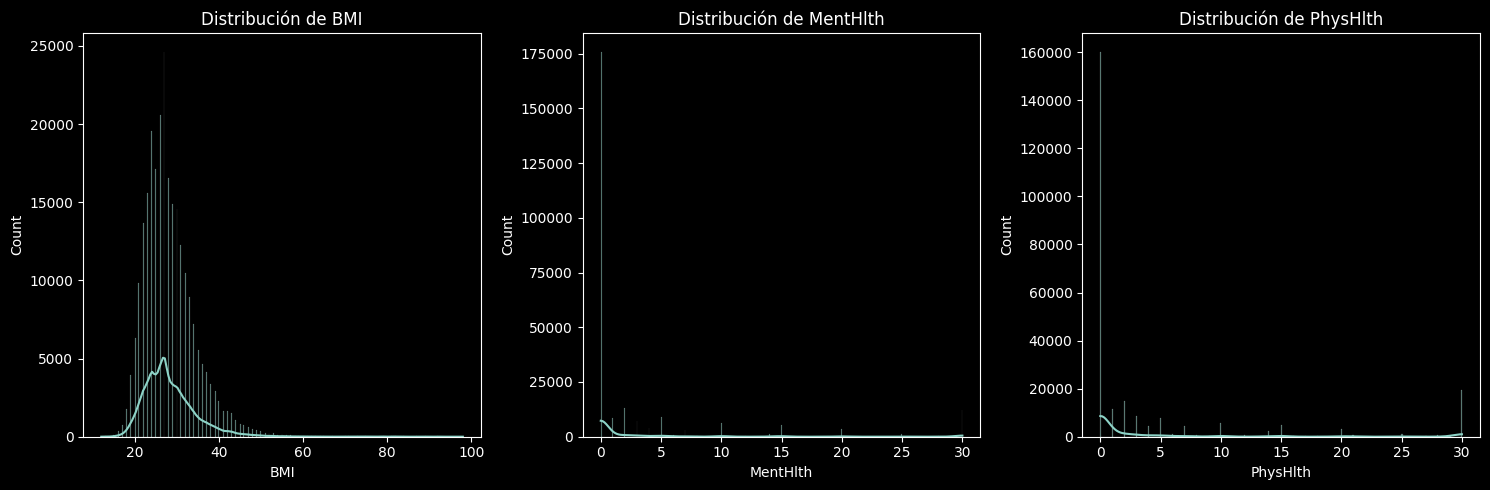


--- Análisis de normalidad para BMI ---
Shapiro-Wilk Test: Estadístico=0.8717, p=0.0000 (Rechaza H0)
D’Agostino’s K^2 Test: Estadístico=126255.7185, p=0.0000 (Rechaza H0)
Anderson-Darling Test:
  Nivel de significancia 15.0% - Valor crítico: 0.5760 (Rechaza H0)
  Nivel de significancia 10.0% - Valor crítico: 0.6560 (Rechaza H0)
  Nivel de significancia 5.0% - Valor crítico: 0.7870 (Rechaza H0)
  Nivel de significancia 2.5% - Valor crítico: 0.9180 (Rechaza H0)
  Nivel de significancia 1.0% - Valor crítico: 1.0920 (Rechaza H0)

--- Análisis de normalidad para MentHlth ---
Shapiro-Wilk Test: Estadístico=0.4869, p=0.0000 (Rechaza H0)
D’Agostino’s K^2 Test: Estadístico=137190.8598, p=0.0000 (Rechaza H0)
Anderson-Darling Test:
  Nivel de significancia 15.0% - Valor crítico: 0.5760 (Rechaza H0)
  Nivel de significancia 10.0% - Valor crítico: 0.6560 (Rechaza H0)
  Nivel de significancia 5.0% - Valor crítico: 0.7870 (Rechaza H0)
  Nivel de significancia 2.5% - Valor crítico: 0.9180 (Rechaza H0

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 253680.
  res = hypotest_fun_out(*samples, **kwds)


D’Agostino’s K^2 Test: Estadístico=104008.5163, p=0.0000 (Rechaza H0)
Anderson-Darling Test:
  Nivel de significancia 15.0% - Valor crítico: 0.5760 (Rechaza H0)
  Nivel de significancia 10.0% - Valor crítico: 0.6560 (Rechaza H0)
  Nivel de significancia 5.0% - Valor crítico: 0.7870 (Rechaza H0)
  Nivel de significancia 2.5% - Valor crítico: 0.9180 (Rechaza H0)
  Nivel de significancia 1.0% - Valor crítico: 1.0920 (Rechaza H0)


In [ ]:
# Graficar histogramas y KDE plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, var in enumerate(numerical_columns):
    sns.histplot(X[var], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
plt.tight_layout()
plt.show()

# Pruebas de normalidad
def check_normality(data, var):
    print(f"\n--- Análisis de normalidad para {var} ---")
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test: Estadístico={stat:.4f}, p={p:.4f} {'(Rechaza H0)' if p < 0.05 else '(No se rechaza H0)'}")

    stat, p = normaltest(data)
    print(f"D’Agostino’s K^2 Test: Estadístico={stat:.4f}, p={p:.4f} {'(Rechaza H0)' if p < 0.05 else '(No se rechaza H0)'}")

    result = anderson(data)
    print("Anderson-Darling Test:")
    for i in range(len(result.critical_values)):
        sig_level = result.significance_level[i]
        crit_val = result.critical_values[i]
        decision = "(Rechaza H0)" if result.statistic > crit_val else "(No se rechaza H0)"
        print(f"  Nivel de significancia {sig_level}% - Valor crítico: {crit_val:.4f} {decision}")

# Aplicar pruebas a cada variable
for var in numerical_columns:
    check_normality(X[var].dropna(), var)

Se concluye que **ninguna de las características numéricas siguen una distribución normal**.

### Desbalanceo de clases

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31452\1777402780.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=Y.Diabetes_binary, palette="Set2")


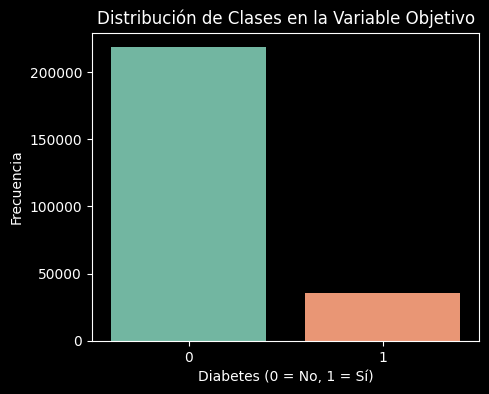

Diabetes_binary
0    0.860667
1    0.139333
Name: proportion, dtype: float64


In [ ]:
# Ver distribución de la variable objetivo
plt.figure(figsize=(5,4))
sns.countplot(x=Y.Diabetes_binary, palette="Set2")
plt.title("Distribución de Clases en la Variable Objetivo")
plt.xlabel("Diabetes (0 = No, 1 = Sí)")
plt.ylabel("Frecuencia")
plt.show()

# Ver proporción de cada clase
print(Y.Diabetes_binary.value_counts(normalize=True))

### Identificación de outliers

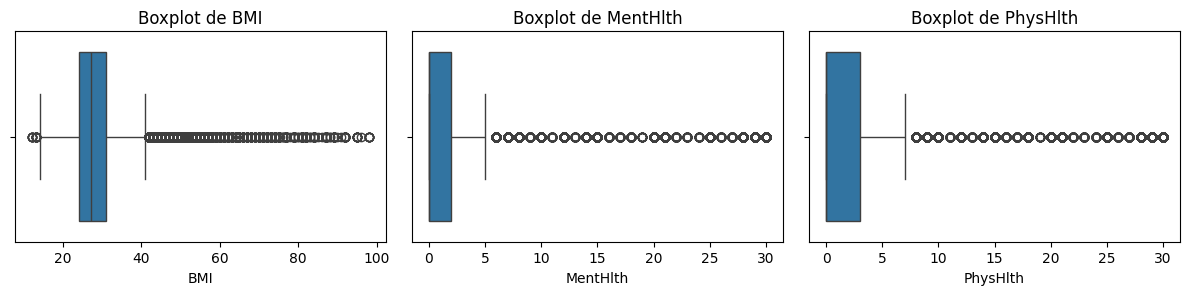

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=X[col])
    plt.title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()

## 1.3. Tipo de datos

In [ ]:
data.dtypes

,0
HighBP,int64
HighChol,int64
CholCheck,int64
BMI,int64
Smoker,int64
Stroke,int64
HeartDiseaseorAttack,int64
PhysActivity,int64
Fruits,int64
Veggies,int64


## 1.4. Análisis

### Análisis bivariado
Se realiza un tipo de estudio según el tipo de variable que sean:
* Numérica - numérica: **Spearman**.
* Numérica - categórica binaria: **Mann-Whitney U** (se muestra el p valor).
* Numérica - categórica (+3 categorías): **Kruskal-Wallis**.
* Categórica - categórica: **Cramer's V**.

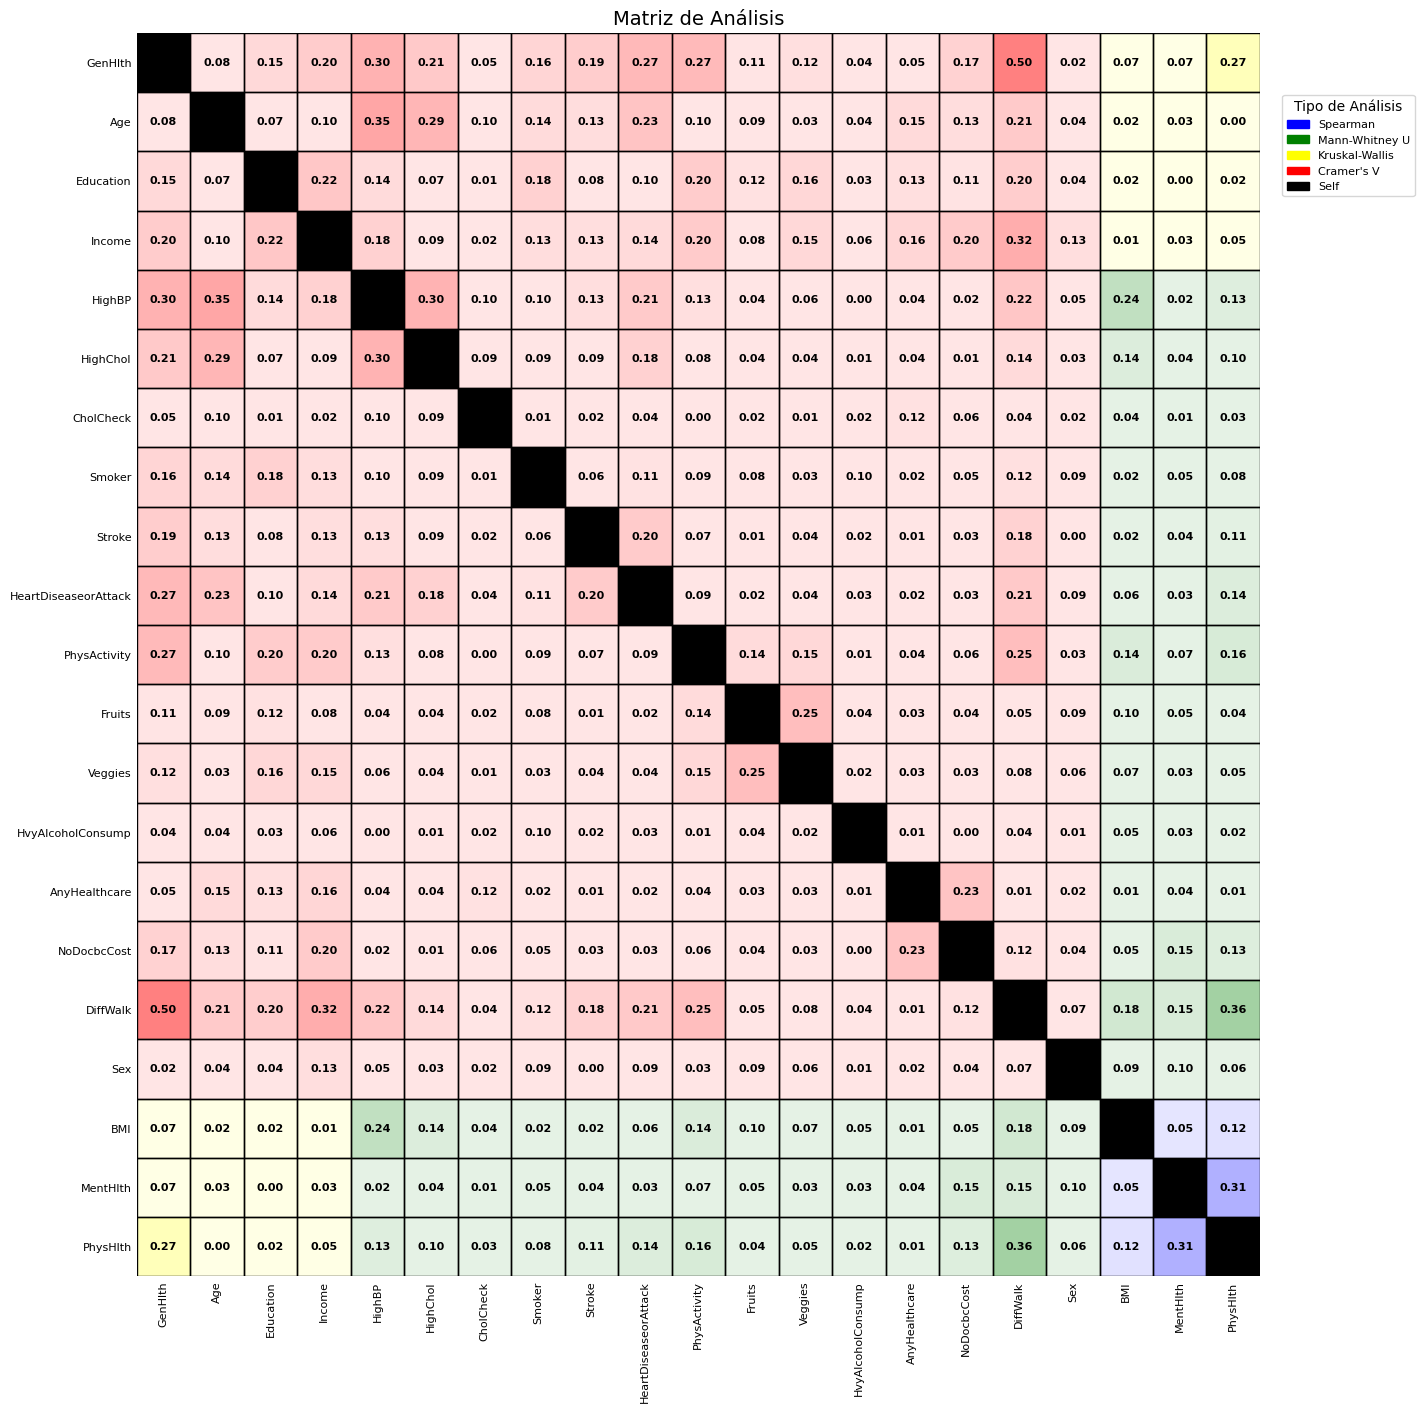

In [ ]:
# Diccionarios para identificación rápida de variables
categorical_vars = set(categorical_nonbinary_columns + categorical_binary_columns)
binary_vars = set(categorical_binary_columns)

def calculate_metric(x, y, x_is_categorical, y_is_categorical, x_is_binary, y_is_binary):
    if not x_is_categorical and not y_is_categorical:
        # Ambas variables son numéricas: uso de correlación de Spearman
        metric, p_value = spearmanr(x, y)
        analysis_type = 'Spearman'
    elif not x_is_categorical and y_is_categorical:
        # x numérica y y categórica
        if y_is_binary:
            # Caso binario: Mann-Whitney U con cálculo del efecto (r = |z|/sqrt(n1+n2))
            group1 = x[y == 0]
            group2 = x[y == 1]
            n1, n2 = len(group1), len(group2)
            try:
                U, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
                U_mean = n1 * n2 / 2.0
                sigma_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12.0)
                z = (U - U_mean) / sigma_U
                metric = abs(z) / np.sqrt(n1 + n2)
            except ValueError:
                metric, p_value = 0, 1.0
            analysis_type = 'Mann-Whitney U'
        else:
            # y categórica con más de 2 niveles: uso de Kruskal-Wallis y cálculo del efecto (eta²)
            groups = [x[y == cat] for cat in np.unique(y)]
            k = len(groups)
            n = len(x)
            if k > 1 and all(len(g) > 1 for g in groups):
                stat, p_value = kruskal(*groups)
                # Efecto estimado: eta² = (H - k + 1) / (n - k)
                metric = max(0, (stat - (k - 1)) / (n - k))
            else:
                metric, p_value = 0, 1.0
            analysis_type = 'Kruskal-Wallis'
    elif x_is_categorical and not y_is_categorical:
        # x categórica y y numérica (caso análogo)
        if x_is_binary:
            group1 = y[x == 0]
            group2 = y[x == 1]
            n1, n2 = len(group1), len(group2)
            try:
                U, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
                U_mean = n1 * n2 / 2.0
                sigma_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12.0)
                z = (U - U_mean) / sigma_U
                metric = abs(z) / np.sqrt(n1 + n2)
            except ValueError:
                metric, p_value = 0, 1.0
            analysis_type = 'Mann-Whitney U'
        else:
            groups = [y[x == cat] for cat in np.unique(x)]
            k = len(groups)
            n = len(y)
            if k > 1 and all(len(g) > 1 for g in groups):
                stat, p_value = kruskal(*groups)
                metric = max(0, (stat - (k - 1)) / (n - k))
            else:
                metric, p_value = 0, 1.0
            analysis_type = 'Kruskal-Wallis'
    else:
        # Ambas variables categóricas: uso de la prueba chi-cuadrado y cálculo de Cramer's V
        contingency_table = pd.crosstab(x, y)
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        n_total = contingency_table.values.sum()
        phi2 = chi2 / n_total
        r, k = contingency_table.shape
        try:
            metric = np.sqrt(phi2 / min((k - 1), (r - 1)))
        except ZeroDivisionError:
            metric = 0
        analysis_type = "Cramer's V"
    return metric, p_value, analysis_type

def create_metric_matrix(X, categorical_nonbinary_columns, categorical_binary_columns, numerical_columns):
    all_columns = categorical_nonbinary_columns + categorical_binary_columns + numerical_columns
    n = len(all_columns)
    metric_matrix = np.zeros((n, n))
    analysis_matrix = [[None] * n for _ in range(n)]

    for i in range(n):
        for j in range(n):
            if i == j:
                metric_matrix[i, j] = 1.0
                analysis_matrix[i][j] = 'Self'
            else:
                x = X[all_columns[i]]
                y = X[all_columns[j]]
                x_is_categorical = all_columns[i] in categorical_vars
                y_is_categorical = all_columns[j] in categorical_vars
                x_is_binary = all_columns[i] in binary_vars
                y_is_binary = all_columns[j] in binary_vars
                metric, p_value, analysis_type = calculate_metric(
                    x, y,
                    x_is_categorical, y_is_categorical,
                    x_is_binary, y_is_binary
                )
                metric_matrix[i, j] = metric
                analysis_matrix[i][j] = analysis_type

    metric_df = pd.DataFrame(metric_matrix, index=all_columns, columns=all_columns)
    analysis_df = pd.DataFrame(analysis_matrix, index=all_columns, columns=all_columns)
    return metric_df, analysis_df

# Generar la matriz de análisis
metric_df, analysis_df = create_metric_matrix(
    X,
    categorical_nonbinary_columns,
    categorical_binary_columns,
    numerical_columns
)

# Definir colores para cada tipo de análisis
analysis_colors = {
    "Spearman": "blue",
    "Mann-Whitney U": "green",
    "Kruskal-Wallis": "yellow",
    "Cramer's V": "red",
    "Self": "black"
}

# Graficar la matriz de análisis
fig, ax = plt.subplots(figsize=(18, 14))
for i in range(metric_df.shape[0]):
    for j in range(metric_df.shape[1]):
        value = metric_df.iloc[i, j]
        analysis_type = analysis_df.iloc[i, j]
        color = analysis_colors.get(analysis_type, "white")
        alpha = max(0.1, min(abs(value), 1))  # transparencia en rango [0.1, 1]
        rgba_color = to_rgba(color, alpha)
        rect = plt.Rectangle((j, i), 1, 1, color=rgba_color, ec='black')
        ax.add_patch(rect)
        ax.text(j + 0.5, i + 0.5, '<0.001' if value < 0.001 else f'{value:.2f}',
                ha='center', va='center', fontsize=8, fontweight='bold')

ax.set_xlim(0, metric_df.shape[1])
ax.set_ylim(0, metric_df.shape[0])
ax.invert_yaxis()
ax.set_xticks(np.arange(metric_df.shape[1]) + 0.5)
ax.set_yticks(np.arange(metric_df.shape[0]) + 0.5)
ax.set_xticklabels(metric_df.columns, rotation=90, fontsize=8)
ax.set_yticklabels(metric_df.index, fontsize=8)
ax.tick_params(axis='both', which='both', length=0)
for spine in ax.spines.values():
    spine.set_visible(False)

# Leyenda
legend_patches = [mpatches.Patch(color=color, label=label)
                  for label, color in analysis_colors.items()]
ax.legend(handles=legend_patches, loc='upper left',
          bbox_to_anchor=(1.02, 0.95), borderaxespad=0.0,
          title="Tipo de Análisis", fontsize=8)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.title("Matriz de Análisis", fontsize=14)
plt.show()

Para Correlación de Spearman 🔵:
* r < 0.10: Correlación despreciable o nula
* 0.10 ≤ r < 0.30: Correlación pequeña o débil
* 0.30 ≤ r < 0.50: Correlación moderada
* 0.50 ≤ r < 0.70: Correlación alta o fuerte
* r ≥ 0.70: Correlación muy fuerte

Para el Tamaño del Efecto derivado de la prueba de Mann-Whitney U 🟢(calculado como * r = |z|/√(n₁+n₂)):
* r ≈ 0.10: Efecto pequeño
* r ≈ 0.30: Efecto moderado
* r ≈ 0.50: Efecto grande

Para la medida de efecto derivada de la prueba de Kruskal-Wallis 🟡(usando eta²):
* 0.01 ≤ η² < 0.06: Efecto pequeño
* 0.06 ≤ η² < 0.14: Efecto moderado
* η² ≥ 0.14: Efecto grande

Para Cramer's V 🔴(utilizado en variables categóricas):
* V < 0.10: Asociación despreciable
* 0.10 ≤ V < 0.30: Asociación débil
* 0.30 ≤ V < 0.50: Asociación moderada
* V ≥ 0.50: Asociación fuerte

Fuente:
Cohen, J. (1988). Statistical Power Analysis for the Behavioral Sciences (2ª ed.). Lawrence Erlbaum Associates.

### Information Gain
obtenido de: https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

Funciona bien con datos categóricos, ordinales y binarios y captura relaciones no lineales.

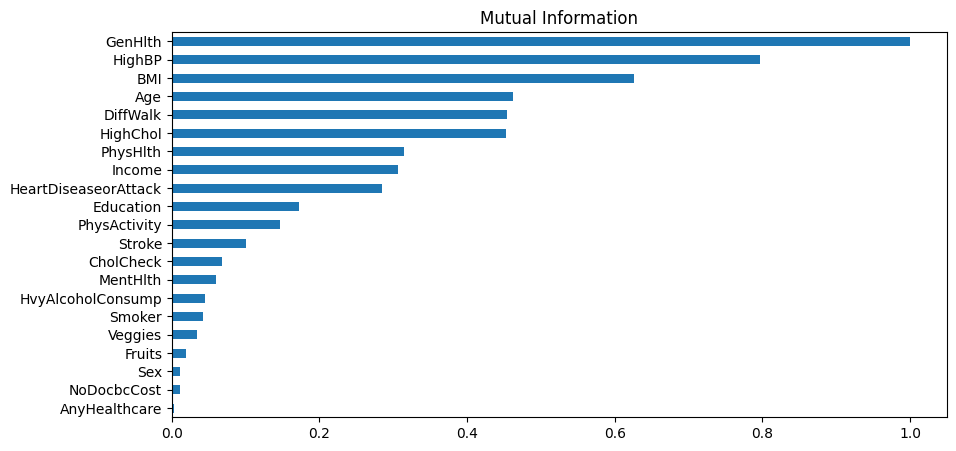

In [ ]:
# Calcular la información mutua
importances = mutual_info_classif(X, Y.Diabetes_binary, discrete_features=True, random_state=42)

# Crear un DataFrame con las importancias de las características
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Normalizar las importancias para comparación
feat_importances /= feat_importances.max()

# Visualizar las importancias de las características
plt.figure(figsize=(10, 5))
feat_importances.sort_values().plot(kind='barh')
plt.title('Mutual Information')
plt.show()

puede ser que el desbalance de las clases afecte a los resultados??

a continuacion:

✅ Se balancea primero el target con SMOTE para evitar que la información mutua esté sesgada hacia la clase mayoritaria.

✅ En lugar de balancear cada característica individualmente, se realiza un submuestreo general para mantener la estructura de correlación entre variables.

✅ Se compara la información mutua antes y después del balanceo para evaluar posibles efectos artificiales introducidos por SMOTE.

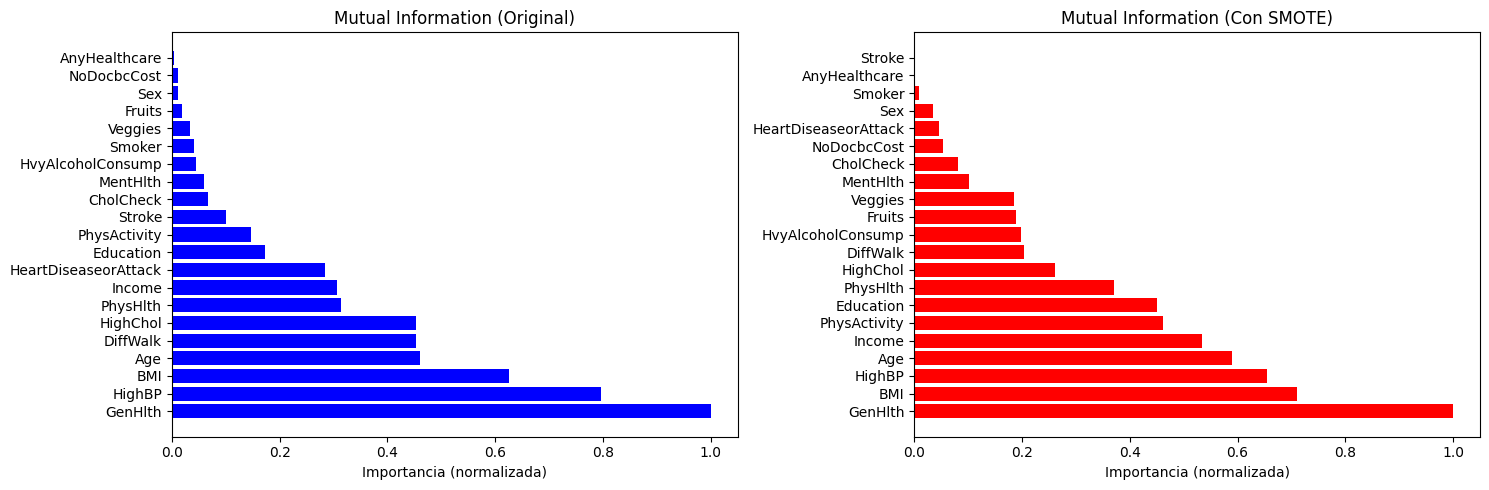

                      Original         SMOTE
Age                   0.461564  5.900373e-01
AnyHealthcare         0.003162  8.047045e-04
BMI                   0.626574  7.093766e-01
CholCheck             0.067869  8.013525e-02
DiffWalk              0.453632  2.035805e-01
Education             0.172791  4.501395e-01
Fruits                0.018651  1.884417e-01
GenHlth               1.000000  1.000000e+00
HeartDiseaseorAttack  0.284593  4.527577e-02
HighBP                0.796362  6.540194e-01
HighChol              0.453215  2.610833e-01
HvyAlcoholConsump     0.045374  1.987966e-01
Income                0.306589  5.338270e-01
MentHlth              0.059504  1.009023e-01
NoDocbcCost           0.010589  5.318546e-02
PhysActivity          0.146907  4.614863e-01
PhysHlth              0.314847  3.710049e-01
Sex                   0.011188  3.471081e-02
Smoker                0.041767  8.438318e-03
Stroke                0.100518  3.771327e-07
Veggies               0.034455  1.848042e-01


In [ ]:
# 1️⃣ Aplicar SMOTE para balancear el target antes del cálculo de MI
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, Y.Diabetes_binary)

# 2️⃣ Definir función para calcular información mutua sin modificar cada variable individualmente
def calculate_mutual_info(X, y, random_state=42):
    """
    Calcula la información mutua entre cada variable en X y el target y sin modificar las variables individualmente.
    """
    return mutual_info_classif(X, y, discrete_features=True, random_state=random_state)

# 3️⃣ Calcular información mutua en el dataset original (sin balancear)
mi_original = calculate_mutual_info(X, Y.Diabetes_binary)

# 4️⃣ Calcular información mutua en el dataset balanceado con SMOTE
mi_smote = calculate_mutual_info(X_smote, y_smote)

# 5️⃣ Crear DataFrames con los resultados
mi_series_original = pd.Series(mi_original, index=X.columns).sort_values(ascending=False)
mi_series_smote = pd.Series(mi_smote, index=X_smote.columns).sort_values(ascending=False)

# Normalizar ambas series para comparación
mi_series_original /= mi_series_original.max()
mi_series_smote /= mi_series_smote.max()

# 6️⃣ Visualización comparativa de Mutual Information antes y después de SMOTE
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de Mutual Information en el dataset original
axes[0].barh(mi_series_original.index, mi_series_original, color="blue")
axes[0].set_title("Mutual Information (Original)")
axes[0].set_xlabel("Importancia (normalizada)")

# Gráfico de Mutual Information en el dataset balanceado con SMOTE
axes[1].barh(mi_series_smote.index, mi_series_smote, color="red")
axes[1].set_title("Mutual Information (Con SMOTE)")
axes[1].set_xlabel("Importancia (normalizada)")

plt.tight_layout()
plt.show()

# Comparar valores numéricamente
mi_comparison = pd.DataFrame({"Original": mi_series_original, "SMOTE": mi_series_smote})
print(mi_comparison)

habría que comentar la capacidad predictiva del modelo con variables que representan objetividad como GenHealth....

### Correlación de pearson
No es la mejor opción dado que la mayoría de variables son categóricas.

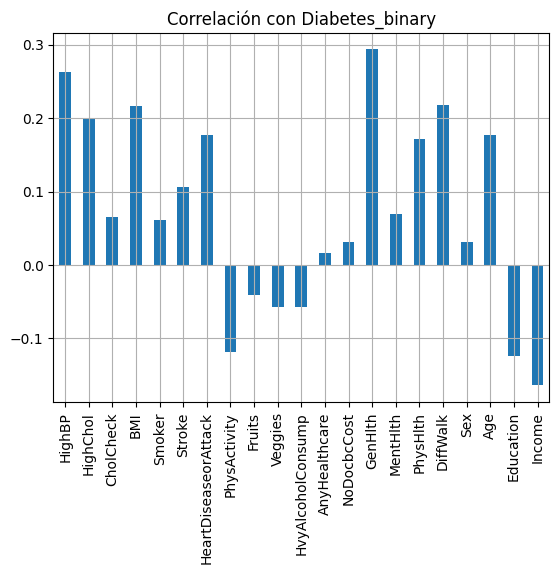

In [ ]:
X.corrwith(Y.Diabetes_binary).plot(kind='bar', grid=True, title="Correlación con Diabetes_binary");

# 2. Preprocesamiento


## Eliminación de variables

* Estas variables tienen información mutua extremadamente baja en ambos escenarios, lo que indica que no aportan valor predictivo al modelo.
 * **AnyHealthcare**
 * **Sex**
 * **Smoker**
 * **Stroke**
 * **NoDocbcCost**
* Estas variables están correlacionadas con otras.
 * **DiffWalk** (fuertemente correlacionado con GenHlth)
 * **PhysHlth** (fuertemente correlacionado con GenHlth)

In [5]:
# variables definitivas
# Definir las variables a eliminar
deleted_vars = [
    "AnyHealthcare",
    "Sex",
    "NoDocbcCost",
    "Smoker",
    "Stroke",
    "PhysHlth",
    "DiffWalk",
]

# Crear las nuevas X e Y
X_filtered = X.drop(columns=deleted_vars)
Y_filtered = Y.copy()  # No modificamos la variable objetivo

# Actualizar las listas de variables después de la eliminación
numerical_columns_filtered = [col for col in numerical_columns if col not in deleted_vars]
categorical_columns_filtered = [col for col in categorical_columns if col not in deleted_vars]
categorical_nonbinary_columns_filtered = [col for col in categorical_nonbinary_columns if col not in deleted_vars]
categorical_binary_columns_filtered = [col for col in categorical_binary_columns if col not in deleted_vars]

# Imprimir las nuevas listas de variables
print("Variables numéricas:", numerical_columns_filtered)
print("Variables categóricas:", categorical_columns_filtered)
print("Variables categóricas no binarias:", categorical_nonbinary_columns_filtered)
print("Variables categóricas binarias:", categorical_binary_columns_filtered)


Variables numéricas: ['BMI', 'MentHlth']
Variables categóricas: ['HighBP', 'HighChol', 'CholCheck', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'Age', 'Education', 'Income']
Variables categóricas no binarias: ['GenHlth', 'Age', 'Education', 'Income']
Variables categóricas binarias: ['HighBP', 'HighChol', 'CholCheck', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump']


## Tratamiento de Outliers y categorización (BMI)
Segun ([fuente](https://www.nhs.uk/conditions/obesity/)):
* Underweight: Below 18.5
* Normal weight: 18.5–24.9
* Pre-obesity: 25.0–29.9
* Obesity class I: 30.0–34.9
* Obesity class II: 35.0–39.9
* Obesity class III: Above 40


Como físicamente creemos que es posible tener un BMI mucho mayor que 40 (p.ej. teniendo una baja estatura y un peso muy elevado), concluimos que vamos a categorizar la variable y no eliminar ninguna fila del dataset.

In [6]:
# Definir los intervalos y etiquetas de clasificación de BMI
bmi_bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf]  # np.inf representa valores mayores a 40
bmi_labels = ["Underweight", "Normal weight", "Pre-obesity", "Obesity class I", "Obesity class II", "Obesity class III"]

# Crear una nueva columna categórica para BMI
X_filtered["BMI"] = pd.cut(X_filtered["BMI"], bins=bmi_bins, labels=bmi_labels, right=True).cat.codes.astype("int64")

# Actualizar las listas de variables categóricas y numéricas
categorical_columns_filtered.append("BMI")
categorical_nonbinary_columns_filtered.append("BMI")  # Ahora es categórica con más de 2 niveles

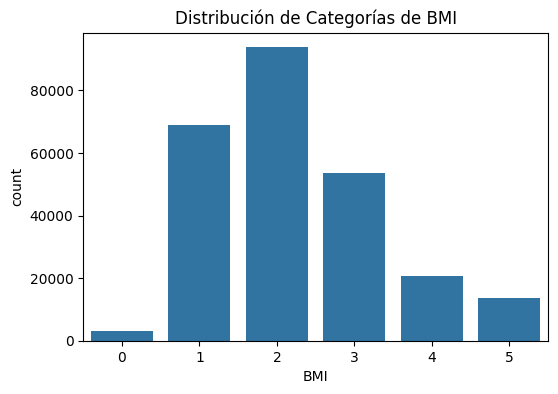

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x=X_filtered['BMI'])
plt.title("Distribución de Categorías de BMI")
plt.show()

## Train-test split

In [8]:
# División en 80% train - 20% test con estratificación del target
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, Y_filtered, test_size=0.2, random_state=42, stratify=Y_filtered
)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# Verificar tamaños de los conjuntos
print("Tamaño de X_train_nofilter:", X_train_filtered.shape)
print("Tamaño de X_test_nofilter:", X_test_filtered.shape)
print("Distribución del target en entrenamiento:\n", y_train.value_counts(normalize=True))
print("Distribución del target en prueba:\n", y_test.value_counts(normalize=True))

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Distribución del target en entrenamiento:\n", y_train.value_counts(normalize=True))
print("Distribución del target en prueba:\n", y_test.value_counts(normalize=True))


Tamaño de X_train_nofilter: (202944, 14)
Tamaño de X_test_nofilter: (50736, 14)
Distribución del target en entrenamiento:
 Diabetes_binary
0                  0.860666
1                  0.139334
Name: proportion, dtype: float64
Distribución del target en prueba:
 Diabetes_binary
0                  0.860671
1                  0.139329
Name: proportion, dtype: float64
Tamaño de X_train: (202944, 21)
Tamaño de X_test: (50736, 21)
Distribución del target en entrenamiento:
 Diabetes_binary
0                  0.860666
1                  0.139334
Name: proportion, dtype: float64
Distribución del target en prueba:
 Diabetes_binary
0                  0.860671
1                  0.139329
Name: proportion, dtype: float64


# 3. Implementación de modelos predictivos
* búsqueda de hiperparámetros: RandomizedSearchCV (RandCV) u Optuna (Opt)
* balanceo de clases: class_weight (wght), oversampling (ov) o undersampling (un)
* atributos: todos (all), selección manual (man_sel), selección automática (aut_sel) o reducción de dimensionalidad (red_dim)

En lugar de evaluar exhaustivamente las 24 combinaciones que surgen al cruzar estas tres dimensiones (método de búsqueda de hiperparámetros, técnica de balanceo de clases y transformación de atributos), se divide el proceso en dos fases, reduciendo así el número total de pruebas a 10. Esto se explica de la siguiente manera:

**Fase 1: Tuning del modelo**

En esta fase se evalúan exclusivamente las combinaciones de métodos que afectan directamente el desempeño del modelo, es decir, se cruzan los dos métodos de búsqueda de hiperparámetros (RandomizedSearchCV y Optuna) con las tres técnicas de balanceo de clases (balanced_weight, oversampling con SMOTE y undersampling). Esto genera 6 *combinaciones*. La finalidad es identificar cuál de estas estrategias produce el mejor desempeño (medido en AUC) sin considerar aún las distintas formas de tratar o transformar los atributos.

**Fase 2: Tuning de datos**

Una vez que se ha determinado la combinación óptima en cuanto a búsqueda y balanceo de clases, se mantiene esa configuración y se prueba junto con las cuatro técnicas de transformación de atributos (usar todas, selección manual, selección automática o reducción de dimensionalidad). De esta forma, se generan 4 *configuraciones* finales sobre los que se evaluará el desempeño final del *modelo* seleccionado.

**ACLARACIÓN**: 
* Opt + ov será una *combinación*
* Opt + ov + aut_sel será una *configuración*
* Logistic Classifier es un *modelo*

## Funciones auxiliares

### Núcleos

In [9]:
import multiprocessing
print("Núcleos disponibles:", multiprocessing.cpu_count())

Núcleos disponibles: 16


In [10]:
n_jobs = 7  # Número de núcleos a utilizar

### Estrategia de validación

In [11]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

### Métricas

Acerca de las dos medidas de AUC:
* **roc_auc_score en el conjunto de test (auc)** evalúa el modelo en un conjunto independiente, generalmente reservado para la evaluación final. Proporciona una única estimación del rendimiento (AUC) en datos nuevos.
* **Media de cv_scores (cv_mean)** se obtiene mediante la validación cruzada en el conjunto de entrenamiento. Permite obtener una medida de robustez y estabilidad del rendimiento, ya que se calcula en distintas particiones.

Ambos valores son importantes: el AUC sobre el conjunto de test indica cómo se espera que se comporte el modelo en producción, mientras que la media de AUC en CV y su desviación ofrecen información sobre la consistencia del modelo y su sensibilidad a la partición de los datos.

In [65]:
def evaluate_and_return_metrics(best_estimator, X_test, y_test, execution_time, best_params, cv_scores, threshold=0.5):
    """
    Evalúa el modelo y muestra las métricas de desempeño, devolviendo un diccionario con las métricas.
    
    Parámetros:
      best_estimator: modelo ajustado obtenido de RandomizedSearchCV.
      X_test: datos de prueba.
      y_test: etiquetas verdaderas de prueba.
      execution_time: tiempo de ejecución en minutos.
      best_params: diccionario de mejores hiperparámetros.
      cv_scores: array de scores obtenido de cross_val_score.
      threshold: umbral de decisión para convertir probabilidades en etiquetas (por defecto 0.5).
    
    Returns:
      metrics_dict: Diccionario con las métricas AUC, Accuracy, Recall, Precision, matriz de confusión,
                    las probabilidades predichas, el tiempo de ejecución, la media y la desviación estándar
                    de los scores obtenidos con cross_val_score y el array de scores.
    """
    
    # Obtener las probabilidades para la clase positiva
    y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    
    print("Execution time: {:.2f} minutes".format(execution_time))
    print("Best Parameters:", best_params)
    print("Threshold:", threshold)
    print("AUC: {:.4f}".format(auc))
    print("Accuracy: {:.4f}".format(accuracy))
    print("Recall: {:.4f}".format(recall))
    print("Precision: {:.4f}".format(precision))
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Cross-Validation AUC: Mean = {:.4f}, Std = {:.4f}".format(cv_mean, cv_std))
    
    metrics_dict = {
        'auc': auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'conf_matrix': conf_matrix,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'execution_time': execution_time,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'cv_scores': cv_scores
    }
    
    return metrics_dict

### Ploteo de resultados

In [13]:
def plot_results(model_results):
    """
    Plotea:
      1. Una tabla resumen con las métricas.
      2. Las curvas ROC de todos los modelos.
      3. Las matrices de confusión en una grilla que se adapta al número de modelos.

    Se asume que:
      - Cada diccionario en model_results contiene:
            "model": nombre del modelo.
            "auc": AUC del modelo.
            "accuracy": Accuracy.
            "recall": Recall.
            "precision": Precision.
            "execution_time": Tiempo de ejecución.
            "y_pred_proba": Array de probabilidades predichas.
            "conf_matrix": Matriz de confusión.
            "cv_mean": Media de los scores obtenidos con cross_val_score.
            "cv_std": Desviación estándar de los scores obtenidos con cross_val_score.
            "cv_scores": Array de scores obtenidos con cross_val_score.
    """

    # ----------------------------------------------------------------------------
    # 1. Crear y mostrar la tabla resumen
    # ----------------------------------------------------------------------------
    summary_data = {
        "Model": [res["model"] for res in model_results],
        "AUC": [res["auc"] for res in model_results],
        "Accuracy": [res["accuracy"] for res in model_results],
        "Recall": [res["recall"] for res in model_results],
        "Precision": [res["precision"] for res in model_results],
        "Score Mean": [res["cv_mean"] for res in model_results],
        "Score Std": [res["cv_std"] for res in model_results],
        "Execution Time (minutes)": [res["execution_time"] for res in model_results]
    }
    summary_df = pd.DataFrame(summary_data)
    print("Summary Table:")
    display(summary_df)

    # ----------------------------------------------------------------------------
    # 2. Plotear las matrices de confusión en una grilla responsiva,
    #    mostrando valores absolutos, porcentaje respecto a la fila y porcentaje respecto a la columna.
    # ----------------------------------------------------------------------------
    n_models = len(model_results)
    n_cols = min(n_models, 3)
    n_rows = math.ceil(n_models / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))

    # Asegurarse de que axs sea una lista (en caso de un solo subplot)
    if n_models == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    for i, res in enumerate(model_results):
        cm = res["conf_matrix"]
        # Crear un array de anotaciones que incluya valor absoluto, % respecto a la fila y % respecto a la columna
        annot_matrix = []
        for row in range(cm.shape[0]):
            annot_row = []
            row_sum = cm[row, :].sum()
            for col in range(cm.shape[1]):
                col_sum = cm[:, col].sum()
                row_pct = (cm[row, col] / row_sum * 100) if row_sum > 0 else 0
                col_pct = (cm[row, col] / col_sum * 100) if col_sum > 0 else 0
                annot_row.append(f"{cm[row, col]:.0f}\n{row_pct:.1f}% (row)\n{col_pct:.1f}% (col)")
            annot_matrix.append(annot_row)
        
        sns.heatmap(cm, annot=annot_matrix, fmt="", cmap='Blues', ax=axs[i],
                    xticklabels=['Predicted Negative', 'Predicted Positive'],
                    yticklabels=['Actual Negative', 'Actual Positive'])
        axs[i].set_title(res["model"])
        axs[i].set_ylabel('Actual')
        axs[i].set_xlabel('Predicted')

    # Ocultar subplots sobrantes, si existen.
    for j in range(i+1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

### Estadísticos

In [14]:
def perform_stat_tests(cv_scores):
    """
    Recibe un diccionario con arrays de scores de validación cruzada y devuelve:
      - df_friedman: DataFrame con el estadístico y p-value del test de Friedman.
      - df_wilcoxon: DataFrame con las comparaciones par a par (Wilcoxon) y p-values ajustados.
      - df_kruskal: DataFrame con el estadístico y p-value del test de Kruskal-Wallis.
      - df_mannwhitney: DataFrame con las comparaciones par a par (Mann-Whitney U) y p-values ajustados.
    
    Parameters:
      cv_scores (dict): Diccionario donde las claves son los nombres de los modelos y
                        los valores son arrays de scores obtenidos en CV.
                        
    Returns:
      df_friedman (DataFrame), df_wilcoxon (DataFrame), df_kruskal (DataFrame), df_mannwhitney (DataFrame)
    """
    # ------------------------------
    # Test de Friedman (para muestras relacionadas)
    # ------------------------------
    friedman_stat, friedman_p_value = friedmanchisquare(*[scores for scores in cv_scores.values()])
    df_friedman = pd.DataFrame({
        'Estadístico Friedman': [friedman_stat],
        'p-value': [friedman_p_value]
    })
    
    # ------------------------------
    # Test de Wilcoxon par a par (para muestras emparejadas) con corrección de Bonferroni
    # ------------------------------
    wilcoxon_results = []
    n_models = len(cv_scores)
    n_comparaciones = n_models * (n_models - 1) / 2
    for (nombre1, scores1), (nombre2, scores2) in itertools.combinations(cv_scores.items(), 2):
        stat, p_value = wilcoxon(scores1, scores2, alternative='greater', zero_method='wilcox')
        p_value_adj = min(p_value * n_comparaciones, 1.0)
        wilcoxon_results.append({
            'Primer Modelo': nombre1,
            'Segundo Modelo': nombre2,
            'Wilcox V': stat,
            'p-value original': p_value,
            'p-value ajustado': p_value_adj
        })
    df_wilcoxon = pd.DataFrame(wilcoxon_results)
    
    # ------------------------------
    # Test de Kruskal-Wallis (para comparar más de dos grupos independientes)
    # ------------------------------
    kruskal_stat, kruskal_p_value = kruskal(*[scores for scores in cv_scores.values()])
    df_kruskal = pd.DataFrame({
        'Estadístico Kruskal-Wallis': [kruskal_stat],
        'p-value': [kruskal_p_value]
    })
    
    # ------------------------------
    # Test de Mann-Whitney U par a par (para muestras independientes) con corrección de Bonferroni
    # Nota: Aunque Mann-Whitney U está diseñado para muestras independientes, se incluye como prueba
    # complementaria a Wilcoxon para corroborar las diferencias entre pares.
    # ------------------------------
    mannwhitney_results = []
    for (nombre1, scores1), (nombre2, scores2) in itertools.combinations(cv_scores.items(), 2):
        stat, p_value = mannwhitneyu(scores1, scores2, alternative='greater')
        p_value_adj = min(p_value * n_comparaciones, 1.0)
        mannwhitney_results.append({
            'Primer Modelo': nombre1,
            'Segundo Modelo': nombre2,
            'U': stat,
            'p-value original': p_value,
            'p-value ajustado': p_value_adj
        })
    df_mannwhitney = pd.DataFrame(mannwhitney_results)
    
    # Mostrar resultados
    print("Resultados del Test de Friedman:")
    print(df_friedman.to_string(index=False))
    print("\nResultados del Test de Wilcoxon:")
    print(df_wilcoxon.to_string(index=False))
    print("\nResultados del Test de Kruskal-Wallis:")
    print(df_kruskal.to_string(index=False))
    print("\nResultados del Test de Mann-Whitney U:")
    print(df_mannwhitney.to_string(index=False))

### SHAP

In [ ]:
def plot_shap (model, X_train):
    """
    Plotea los valores SHAP para un modelo dado.
    
    Parameters:
      model: modelo entrenado (ej. RandomForestClassifier).
      X_train: datos de entrenamiento..
    """
    # Inicializar el explainer para modelos lineales utilizando LinearExplainer
    explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test)

    # -----------------------
    # Visualizaciones básicas con SHAP

    # a) Force plot para explicar una predicción individual (usa la versión estática)
    shap.initjs()  # Inicializa las visualizaciones interactivas, aunque en VS Code se recomienda la opción estática
    force_plot = shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :], matplotlib=True)
    plt.show()

    # b) Summary plot para ver la importancia global de las características
    shap.summary_plot(shap_values, X_test)
    plt.show()

    # -----------------------
    # Visualizaciones avanzadas

    # a) Waterfall plot para explicar en detalle una predicción individual
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[0, :],
        base_values=explainer.expected_value,
        data=X_test.iloc[0, :],
        feature_names=X_test.columns.tolist()
    ))
    plt.show()

    # b) Decision plot para visualizar cómo se suma la contribución de cada característica
    shap.decision_plot(explainer.expected_value, shap_values, X_test, ignore_warnings=True)
    plt.show()

    # -----------------------
    # Evaluación de la estabilidad de las predicciones
    # Calcular la varianza de los SHAP values para cada característica y observar su dispersión
    shap_df = pd.DataFrame(shap_values, columns=X_test.columns)
    shap_variance = shap_df.var().sort_values(ascending=False)
    print("Varianza de los valores SHAP por característica:")
    print(shap_variance)

### Maximize F1 score

In [73]:
def maximize_f1_score(model, X_train, y_train):
    model.fit(X_train, y_train)

    # 1. Obtener las probabilidades de predicción para la clase positiva (índice 1)
    y_prob = model.predict_proba(X_test)

    # 2. Evaluar diferentes umbrales para optimizar el F1-score
    thresholds = np.arange(0.0, 1.0, 0.01)
    f1_scores = []

    for thresh in thresholds:
        # Convertir probabilidades a predicciones binarias usando el umbral actual
        y_pred = (y_prob[:, 1] >= thresh).astype(int)
        score = f1_score(y_test, y_pred)
        f1_scores.append(score)

    # Seleccionar el umbral óptimo que maximiza el F1-score
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    print("El umbral óptimo es:", optimal_threshold)

    # 3. Graficar el F1-score en función del umbral
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker='o')
    plt.xlabel('Umbral de decisión')
    plt.ylabel('F1 Score')
    plt.title('Optimización del Umbral - F1 Score')
    plt.grid(True)
    plt.show()

    return optimal_threshold

## Dummy Classifier

In [15]:
model = DummyClassifier(strategy="most_frequent", random_state=42)
start_time = time.time()
model.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60

cv_scores = cross_val_score(model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_dummy = evaluate_and_return_metrics(model, X_test_filtered, y_test_filtered, execution_time, {"strategy": "most_frequent"}, cv_scores)

del model, start_time, end_time, execution_time, cv_scores

Execution time: 0.00 minutes
Best Parameters: {'strategy': 'most_frequent'}
AUC: 0.5000
Accuracy: 0.8607
Recall: 0.0000
Precision: 0.0000
Confusion Matrix:
[[43667     0]
 [ 7069     0]]
Cross-Validation AUC: Mean = 0.5000, Std = 0.0000


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Logistic Regression

### Fase 1: tuning del modelo

#### Combinación 1: RandomizedSearchCV + Undersampling

In [44]:
param_distributions = {
    'clf_lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf_lr__penalty': ['l1', 'l2']
}

In [45]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions, scoring='roc_auc', cv=cv, n_iter=12, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_randcv_un = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 0.94 minutes
Best Parameters: {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}
AUC: 0.8187
Accuracy: 0.7308
Recall: 0.7621
Precision: 0.3103
Confusion Matrix:
[[31693 11974]
 [ 1682  5387]]
Cross-Validation AUC: Mean = 0.8228, Std = 0.0029


#### Combinación 2: RandomizedSearchCV + Oversampling

In [50]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions, scoring='roc_auc', cv=cv, n_iter=12, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_randcv_ov = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 2.25 minutes
Best Parameters: {'clf_lr__penalty': 'l1', 'clf_lr__C': 0.001}
AUC: 0.8132
Accuracy: 0.7189
Recall: 0.7728
Precision: 0.3015
Confusion Matrix:
[[31011 12656]
 [ 1606  5463]]
Cross-Validation AUC: Mean = 0.8177, Std = 0.0029


#### Combinación 3: RandomizedSearchCV + class_weight

In [46]:
pipeline = ImbPipeline([
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000, class_weight='balanced'))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_randcv_wght = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_,cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 1.22 minutes
Best Parameters: {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}
AUC: 0.8187
Accuracy: 0.7315
Recall: 0.7638
Precision: 0.3111
Confusion Matrix:
[[31712 11955]
 [ 1670  5399]]
Cross-Validation AUC: Mean = 0.8229, Std = 0.0029


#### Combinación 4: Optuna + Undersampling

In [47]:
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    pipeline = ImbPipeline([
        ('undersample', RandomUnderSampler(random_state=42)),
        ('clf_lr', LogisticRegression(C=C, penalty=penalty, solver='saga', max_iter=1000, random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=12)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver='saga',
    max_iter=1000,
    random_state=42)
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lr', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_opt_un = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-10 09:00:19,599] A new study created in memory with name: no-name-f00d1242-7241-4782-b090-4c0e20d0508d
[I 2025-04-10 09:00:24,523] Trial 0 finished with value: 0.8228217061699269 and parameters: {'C': 10.647189989696367, 'penalty': 'l1'}. Best is trial 0 with value: 0.8228217061699269.
[I 2025-04-10 09:00:29,402] Trial 1 finished with value: 0.8228217709534684 and parameters: {'C': 15.253665971591957, 'penalty': 'l1'}. Best is trial 1 with value: 0.8228217709534684.
[I 2025-04-10 09:00:31,051] Trial 2 finished with value: 0.817296883790832 and parameters: {'C': 0.0015099785053579425, 'penalty': 'l1'}. Best is trial 1 with value: 0.8228217709534684.
[I 2025-04-10 09:00:36,051] Trial 3 finished with value: 0.8228216940453279 and parameters: {'C': 5.835131090875189, 'penalty': 'l1'}. Best is trial 1 with value: 0.8228217709534684.
[I 2025-04-10 09:00:41,034] Trial 4 finished with value: 0.822821720326305 and parameters: {'C': 12.258851555597815, 'penalty': 'l1'}. Best is trial 

Execution time: 0.85 minutes
Best Parameters: {'C': 0.10829700409423945, 'penalty': 'l2'}
AUC: 0.8187
Accuracy: 0.7309
Recall: 0.7621
Precision: 0.3103
Confusion Matrix:
[[31694 11973]
 [ 1682  5387]]
Cross-Validation AUC: Mean = 0.8228, Std = 0.0029


#### Combinación 5: Optuna + Oversampling

In [48]:
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf_lr', LogisticRegression(C=C, penalty=penalty, solver='saga', max_iter=1000, random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=12)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver='saga',
    max_iter=1000,
    random_state=42)
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf_lr', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_opt_ov = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-10 09:01:16,879] A new study created in memory with name: no-name-3c3f40d3-98cc-4137-93a6-4807b2ccd707
[I 2025-04-10 09:01:32,582] Trial 0 finished with value: 0.8137744604097342 and parameters: {'C': 5.145341509524655, 'penalty': 'l2'}. Best is trial 0 with value: 0.8137744604097342.
[I 2025-04-10 09:01:44,537] Trial 1 finished with value: 0.8170477026876888 and parameters: {'C': 0.001731867454465322, 'penalty': 'l1'}. Best is trial 1 with value: 0.8170477026876888.
[I 2025-04-10 09:01:56,166] Trial 2 finished with value: 0.8137747337387446 and parameters: {'C': 4.683793023165876, 'penalty': 'l2'}. Best is trial 1 with value: 0.8170477026876888.
[I 2025-04-10 09:02:08,070] Trial 3 finished with value: 0.8146347104180285 and parameters: {'C': 0.010779396782922104, 'penalty': 'l2'}. Best is trial 1 with value: 0.8170477026876888.
[I 2025-04-10 09:02:19,272] Trial 4 finished with value: 0.8137727475098429 and parameters: {'C': 35.258420692840936, 'penalty': 'l2'}. Best is tria

Execution time: 2.59 minutes
Best Parameters: {'C': 0.0012021005061161115, 'penalty': 'l1'}
AUC: 0.8130
Accuracy: 0.7192
Recall: 0.7722
Precision: 0.3017
Confusion Matrix:
[[31031 12636]
 [ 1610  5459]]
Cross-Validation AUC: Mean = 0.8176, Std = 0.0029


#### Combinación 6: Optuna + class_weight

In [49]:
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    pipeline = Pipeline([
        ('clf_lr', LogisticRegression(C=C, penalty=penalty, solver='saga', class_weight='balanced', max_iter=1000, random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=12)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver='saga',
    class_weight='balanced',
    max_iter=1000,
    random_state=42)
pipeline = Pipeline([
    ('clf_lr', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_opt_wght = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-10 09:04:10,896] A new study created in memory with name: no-name-b3116fc4-d8d5-4061-ba22-7046074307cf
[I 2025-04-10 09:04:17,220] Trial 0 finished with value: 0.8228677315910925 and parameters: {'C': 0.057208780919961455, 'penalty': 'l2'}. Best is trial 0 with value: 0.8228677315910925.
[I 2025-04-10 09:04:23,986] Trial 1 finished with value: 0.8228615817352228 and parameters: {'C': 0.1474076503244596, 'penalty': 'l1'}. Best is trial 0 with value: 0.8228677315910925.
[I 2025-04-10 09:04:31,053] Trial 2 finished with value: 0.8228621049832123 and parameters: {'C': 8.828737865038923, 'penalty': 'l1'}. Best is trial 0 with value: 0.8228677315910925.
[I 2025-04-10 09:04:38,437] Trial 3 finished with value: 0.8228622406241785 and parameters: {'C': 145.903103334051, 'penalty': 'l2'}. Best is trial 0 with value: 0.8228677315910925.
[I 2025-04-10 09:04:46,386] Trial 4 finished with value: 0.8228621637808091 and parameters: {'C': 0.27523156010536143, 'penalty': 'l1'}. Best is trial 

Execution time: 1.44 minutes
Best Parameters: {'C': 0.057208780919961455, 'penalty': 'l2'}
AUC: 0.8187
Accuracy: 0.7315
Recall: 0.7638
Precision: 0.3111
Confusion Matrix:
[[31714 11953]
 [ 1670  5399]]
Cross-Validation AUC: Mean = 0.8229, Std = 0.0029


#### Combinación 7: RandomizedSearchCV + Undersampling + Oversampling

In [40]:
pipeline = ImbPipeline([
    ('balance', SMOTEENN(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions, scoring='roc_auc', cv=cv, n_iter=12, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_randcv_un_ov = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 45.29 minutes
Best Parameters: {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.01}
AUC: 0.8050
Accuracy: 0.7338
Recall: 0.7281
Precision: 0.3077
Confusion Matrix:
[[32085 11582]
 [ 1922  5147]]
Cross-Validation AUC: Mean = 0.8084, Std = 0.0028


#### Combinación 8: RandomizedSearchCV + Undersampling + Oversampling + class_weight

In [41]:
pipeline = ImbPipeline([
    ('balance', SMOTEENN(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', class_weight='balanced', max_iter=1000))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions, scoring='roc_auc', cv=cv, n_iter=12, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_randcv_un_ov_wght = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 44.84 minutes
Best Parameters: {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.01}
AUC: 0.8048
Accuracy: 0.7191
Recall: 0.7489
Precision: 0.2979
Confusion Matrix:
[[31192 12475]
 [ 1775  5294]]
Cross-Validation AUC: Mean = 0.8082, Std = 0.0028


#### Resultados y conclusiones
Basándonos en los resultados estadísticos, se observa lo siguiente:
**Modelo1 (RandCV + Un)** destaca por ser significativamente mejor que modelo2, modelo5, modelo7 y modeloo8 y, al no mostrar diferencias significativas con respecto a modelo3, modelo4 y modelo6, resulta una opción robusta. 

**Conclusión:**  
Se utilizará RandomizedSearchCV + Undersampling para Logistic Regression.

Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Combination 0: Dummy Classifier,0.500000,0.860671,0.000000,0.000000,0.500000,0.000000,0.000185
1,Combination 1: RandomizedSearchCV + Undersampling,0.818685,0.730842,0.762060,0.310293,0.822828,0.002907,0.935462
2,Combination 2: RandomizedSearchCV + Oversampling,0.813198,0.718898,0.772811,0.301507,0.817695,0.002853,2.249405
3,Combination 3: RandomizedSearchCV + class_weight,0.818724,0.731453,0.763757,0.311110,0.822866,0.002873,1.222312
4,Combination 4: Optuna + Undersampling,0.818685,0.730862,0.762060,0.310311,0.822828,0.002907,0.851792
5,Combination 5: Optuna + Oversampling,0.813018,0.719213,0.772245,0.301686,0.817575,0.002914,2.587904
6,Combination 6: Optuna + class_weight,0.818727,0.731492,0.763757,0.311146,0.822868,0.002871,1.440393
7,Combination 7: RandomizedSearchCV + Undersampling + Oversampling,0.804982,0.733838,0.728109,0.307669,0.808426,0.002844,45.289457
8,Combination 8: RandomizedSearchCV + Undersampling + Oversampling + class_weight,0.804793,0.719134,0.748904,0.297935,0.808227,0.002831,44.844567


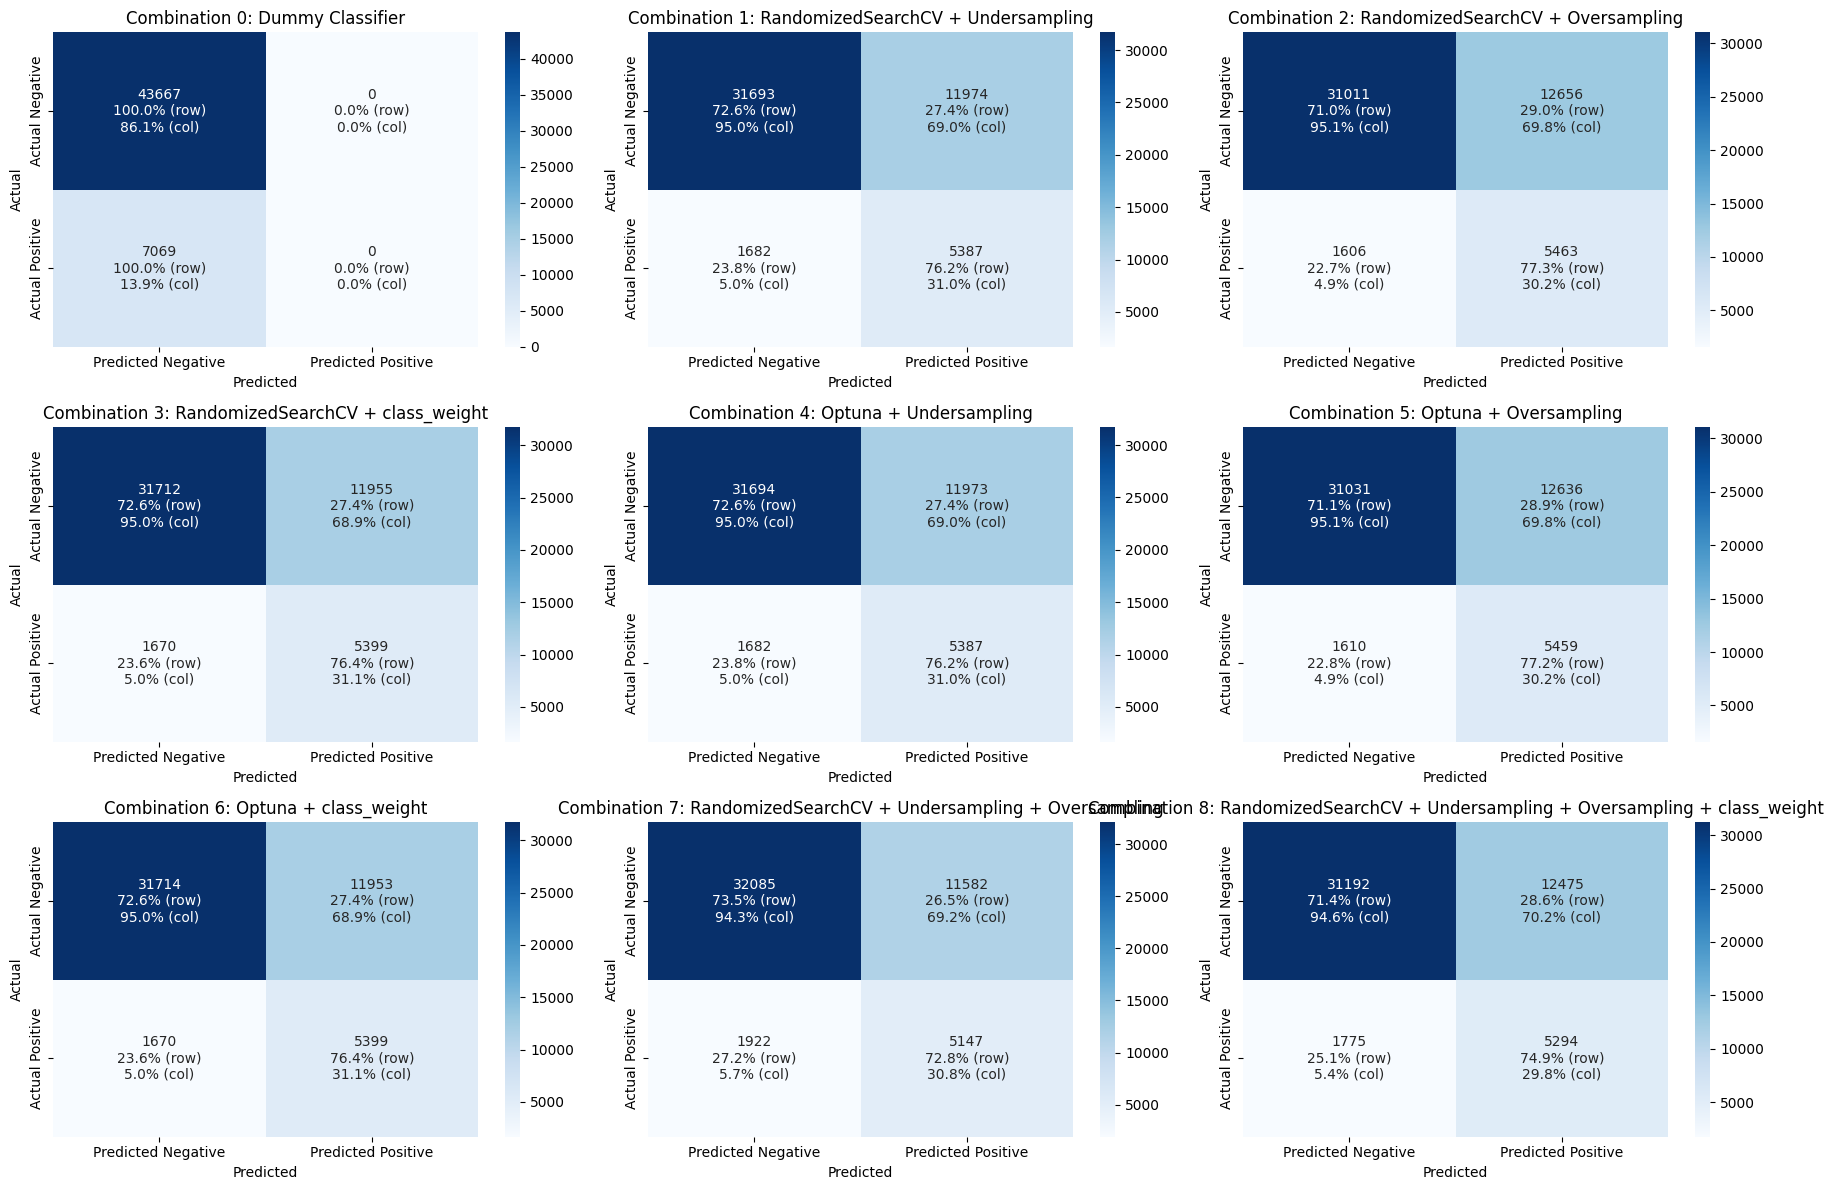

In [81]:
# Creamos el diccionario model_results utilizando los diccionarios de métricas de cada modelo:
model_results = [
    {
        "model": "Combination 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Combination 1: RandomizedSearchCV + Undersampling",
        **metrics_lr_randcv_un
    },
    {
        "model": "Combination 2: RandomizedSearchCV + Oversampling",
        **metrics_lr_randcv_ov
    },
    {
        "model": "Combination 3: RandomizedSearchCV + class_weight",
        **metrics_lr_randcv_wght
    },
    {
        "model": "Combination 4: Optuna + Undersampling",
        **metrics_lr_opt_un
    },
    {
        "model": "Combination 5: Optuna + Oversampling",
        **metrics_lr_opt_ov
    },
    {
        "model": "Combination 6: Optuna + class_weight",
        **metrics_lr_opt_wght
    },
    {
        "model": "Combination 7: RandomizedSearchCV + Undersampling + Oversampling",
        **metrics_lr_randcv_un_ov
    },
    {
        "model": "Combination 8: RandomizedSearchCV + Undersampling + Oversampling + class_weight",
        **metrics_lr_randcv_un_ov_wght
    }
]

plot_results(model_results)

del model_results

In [52]:
cv_scores = {
    'Combination 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Combination 1: RandCV + Un': metrics_lr_randcv_un['cv_scores'],
    'Combination 2: RandCV + Ov': metrics_lr_randcv_ov['cv_scores'],
    'Combination 3: RandCV + wght': metrics_lr_randcv_wght['cv_scores'],
    'Combination 4: Opt + Un': metrics_lr_opt_un['cv_scores'],
    'Combination 5: Opt + Ov': metrics_lr_opt_ov['cv_scores'],
    'Combination 6: Opt + wght': metrics_lr_opt_wght['cv_scores'],
    'Combination 7: RandCV + Un + Ov': metrics_lr_randcv_un_ov['cv_scores'],
    'Combination 8: RandCV + Un + Ov + wght': metrics_lr_randcv_un_ov_wght['cv_scores']
}

perform_stat_tests(cv_scores)

del cv_scores


Resultados del Test de Friedman:
 Estadístico Friedman      p-value
            74.293333 6.831817e-13

Resultados del Test de Wilcoxon:
                  Primer Modelo                         Segundo Modelo  Wilcox V  p-value original  p-value ajustado
Combination 0: Dummy Classifier             Combination 1: RandCV + Un       0.0          1.000000          1.000000
Combination 0: Dummy Classifier             Combination 2: RandCV + Ov       0.0          1.000000          1.000000
Combination 0: Dummy Classifier           Combination 3: RandCV + wght       0.0          1.000000          1.000000
Combination 0: Dummy Classifier                Combination 4: Opt + Un       0.0          1.000000          1.000000
Combination 0: Dummy Classifier                Combination 5: Opt + Ov       0.0          1.000000          1.000000
Combination 0: Dummy Classifier              Combination 6: Opt + wght       0.0          1.000000          1.000000
Combination 0: Dummy Classifier        Combi

EXPLICACION: Cuando se realizan múltiples comparaciones, como en el caso de comparar de forma par a par los 6 modelos (lo que implica 15 pruebas independientes), aumenta la probabilidad de obtener resultados significativos por azar (errores de Tipo I). Esto se debe a que, con cada prueba adicional, la probabilidad acumulada de cometer un falso positivo crece. Por ello, ajustar el p-value mediante métodos como la corrección de Bonferroni es fundamental.

La corrección de Bonferroni consiste en dividir el nivel de significancia original (por ejemplo, 0.05) por el número total de comparaciones. De este modo, se establece un umbral de significancia más estricto para cada prueba individual, lo que ayuda a controlar el error familiar y reduce la posibilidad de que las diferencias observadas sean simplemente fruto del azar. En resumen, este ajuste garantiza que las conclusiones obtenidas sobre la superioridad o inferioridad de un modelo frente a otro sean estadísticamente robustas y confiables, aportando mayor rigor a la validación de los resultados en el estudio.

### Fase 2: tuning de los datos

#### Configuración 1: variables seleccionadas manualmente

In [56]:
metrics_lr_man_sel = metrics_lr_randcv_un

#### Configuración 2: variables seleccionadas automáticamente

In [58]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000))
])

# Espacio de hiperparámetros
param_distributions_sfm = {
    'selector__estimator__n_estimators': [50, 100, 150],
    'selector__threshold': ['mean', 'median', 0.01, 0.05],
    'clf_lr__C': [0.001, 0.01, 0.1, 1, 10],
    'clf_lr__penalty': ['l1', 'l2']
}

start_time = time.time()
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions_sfm,
    scoring='roc_auc',
    cv=cv,
    n_iter=50,
    n_jobs=n_jobs,
    random_state=42,
)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(pipeline, X_test, y_test, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_aut_sel = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

selected_features = X_train.columns[best_model.named_steps['selector'].get_support()].tolist()
print("Variables seleccionadas:", selected_features)

del pipeline, param_distributions_sfm, start_time, search, end_time, execution_time, best_model, cv_scores, selected_features

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 14.79 minutes
Best Parameters: {'selector__threshold': 0.01, 'selector__estimator__n_estimators': 50, 'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}
AUC: 0.8167
Accuracy: 0.7296
Recall: 0.7605
Precision: 0.3089
Confusion Matrix:
[[31641 12026]
 [ 1693  5376]]
Cross-Validation AUC: Mean = 0.8078, Std = 0.0090
Variables seleccionadas: ['HighBP', 'HighChol', 'BMI', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


#### Configuración 3: reducción de dimensionalidad

In [59]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('umap', umap.UMAP(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000))
])

param_distributions_umap = {
    'umap__n_components': [3, 5, 7, 10],
    'umap__n_neighbors': [5, 10, 15, 30],
    'umap__min_dist': [0.0, 0.1, 0.2, 0.3],
    'clf_lr__C': [0.001, 0.01, 0.1, 1, 10],
    'clf_lr__penalty': ['l1', 'l2']
}

start_time = time.time()
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions_umap,
    scoring='roc_auc',
    cv=cv,
    n_iter=50,
    n_jobs=n_jobs,
    random_state=42,
)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(pipeline, X_test, y_test, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_red_dim = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, param_distributions_umap, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\

Execution time: 112.35 minutes
Best Parameters: {'umap__n_neighbors': 30, 'umap__n_components': 10, 'umap__min_dist': 0.0, 'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}
AUC: 0.7791
Accuracy: 0.6726
Recall: 0.7980
Precision: 0.2709
Confusion Matrix:
[[28482 15185]
 [ 1428  5641]]
Cross-Validation AUC: Mean = 0.7415, Std = 0.0073


#### Configuración 4: todas las variables

In [59]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_test, y_test, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_all = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 5.76 minutes
Best Parameters: {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}
AUC: 0.8195
Accuracy: 0.7317
Recall: 0.7630
Precision: 0.3113
Confusion Matrix:
[[31731 11936]
 [ 1675  5394]]
Cross-Validation AUC: Mean = 0.8190, Std = 0.0085


#### Resumen y conclusiones

Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Configuration 0: Dummy Classifier,0.500000,0.860671,0.000000,0.000000,0.500000,0.000000,0.000233
1,Configuration 1: Variables seleccionadas manualmente,0.818685,0.730842,0.762060,0.310293,0.822828,0.002907,0.704956
2,Configuration 2: Variables seleccionadas automáticamente,0.816701,0.729600,0.760504,0.308930,0.807799,0.008963,14.790197
3,Configuration 3: reducción de dimensionalidad,0.779140,0.672560,0.797991,0.270863,0.741548,0.007252,112.352288
4,Configuration 4: todas las variables,0.823368,0.731852,0.765711,0.311782,0.823256,0.002846,5.223937


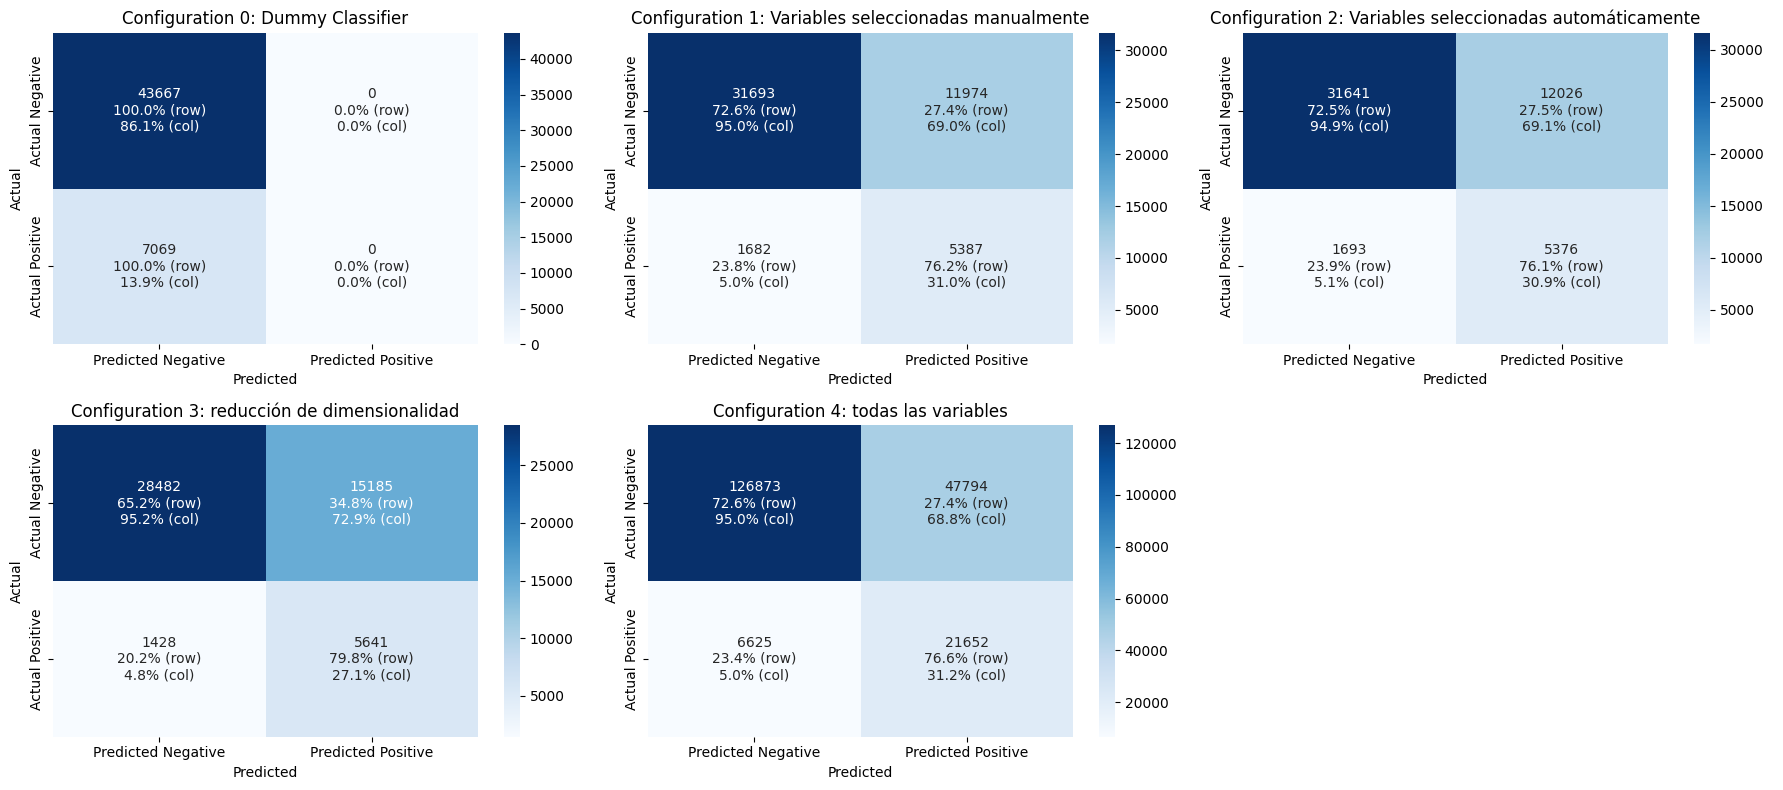

In [61]:
# Creamos el diccionario model_results utilizando los diccionarios de métricas de cada modelo:
model_results = [
    {
        "model": "Configuration 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Configuration 1: Variables seleccionadas manualmente",
        **metrics_lr_man_sel
    },
    {
        "model": "Configuration 2: Variables seleccionadas automáticamente",
        **metrics_lr_aut_sel
    },
    {
        "model": "Configuration 3: reducción de dimensionalidad",
        **metrics_lr_red_dim
    },
    {
        "model": "Configuration 4: todas las variables",
        **metrics_lr_all
    }
]

plot_results(model_results)

In [ ]:
cv_scores = {
    'Configuration 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Configuration 1: man_sel': metrics_lr_man_sel['cv_scores'],
    'Configuration 2: aut_sel': metrics_lr_aut_sel['cv_scores'],
    'Configuration 3: red_dim': metrics_lr_red_dim['cv_scores'],
    'Configuration 4: all': metrics_lr_all['cv_scores']
}

perform_stat_tests(cv_scores)

Resultados del Test de Friedman:
 Estadístico Friedman      p-value
                38.08 1.078775e-07

Resultados del Test de Wilcoxon:
                    Primer Modelo           Segundo Modelo  Wilcox V  p-value original  p-value ajustado
Configuration 0: Dummy Classifier Configuration 1: man_sel       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier Configuration 2: aut_sel       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier Configuration 3: red_dim       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier     Configuration 4: all       0.0          1.000000          1.000000
         Configuration 1: man_sel Configuration 2: aut_sel      55.0          0.000977          0.009766
         Configuration 1: man_sel Configuration 3: red_dim      55.0          0.000977          0.009766
         Configuration 1: man_sel     Configuration 4: all      12.0          0.947266          1.000000
         Configuration 

(   Estadístico Friedman       p-value
 0                 38.08  1.078775e-07,
                        Primer Modelo            Segundo Modelo  Wilcox V  \
 0  Configuration 0: Dummy Classifier  Configuration 1: man_sel       0.0   
 1  Configuration 0: Dummy Classifier  Configuration 2: aut_sel       0.0   
 2  Configuration 0: Dummy Classifier  Configuration 3: red_dim       0.0   
 3  Configuration 0: Dummy Classifier      Configuration 4: all       0.0   
 4           Configuration 1: man_sel  Configuration 2: aut_sel      55.0   
 5           Configuration 1: man_sel  Configuration 3: red_dim      55.0   
 6           Configuration 1: man_sel      Configuration 4: all      12.0   
 7           Configuration 2: aut_sel  Configuration 3: red_dim      55.0   
 8           Configuration 2: aut_sel      Configuration 4: all       0.0   
 9           Configuration 3: red_dim      Configuration 4: all       0.0   
 
    p-value original  p-value ajustado  
 0          1.000000          1

para emplear SHAP se entrena el pipeline completo, pero luego se extrae únicamente el clasificador logístico (usando final_model_lr.named_steps['clf_lr']). De esta forma, SHAP puede trabajar con un objeto que contenga los parámetros de un modelo lineal.

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


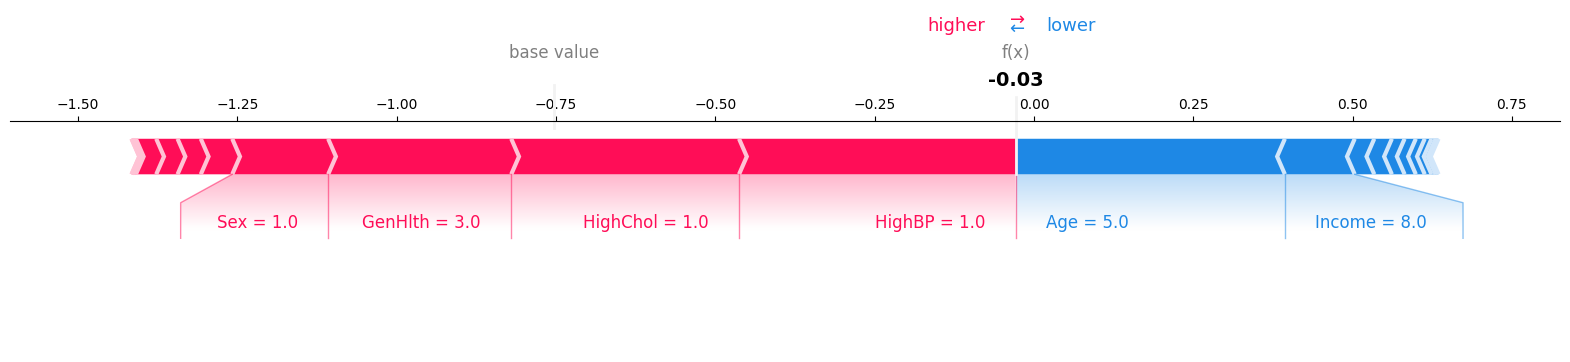

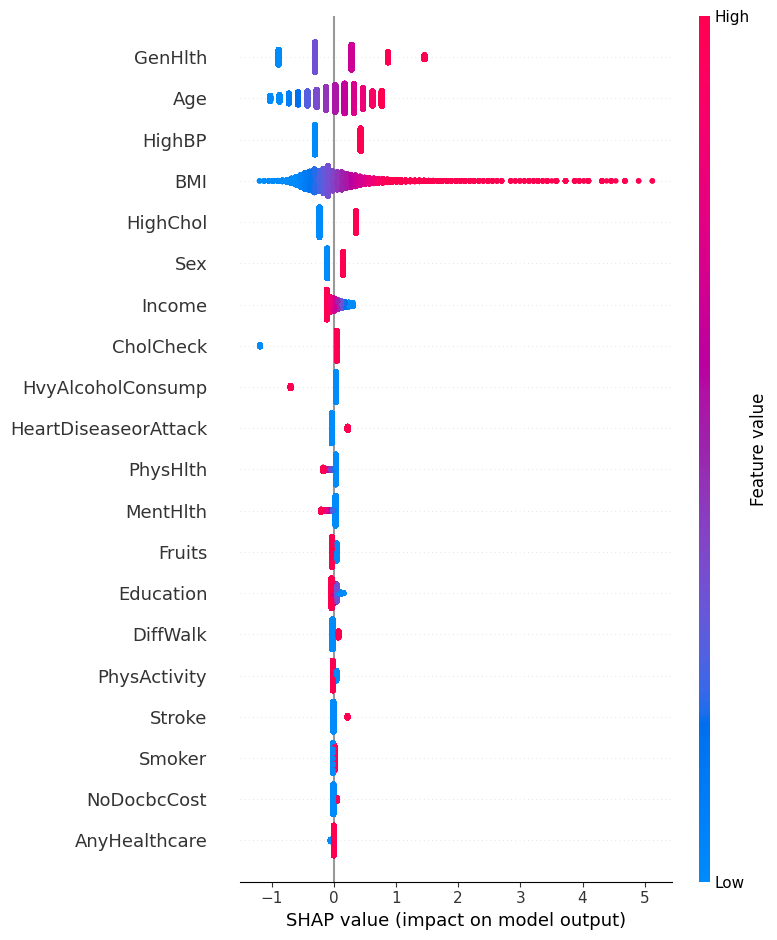

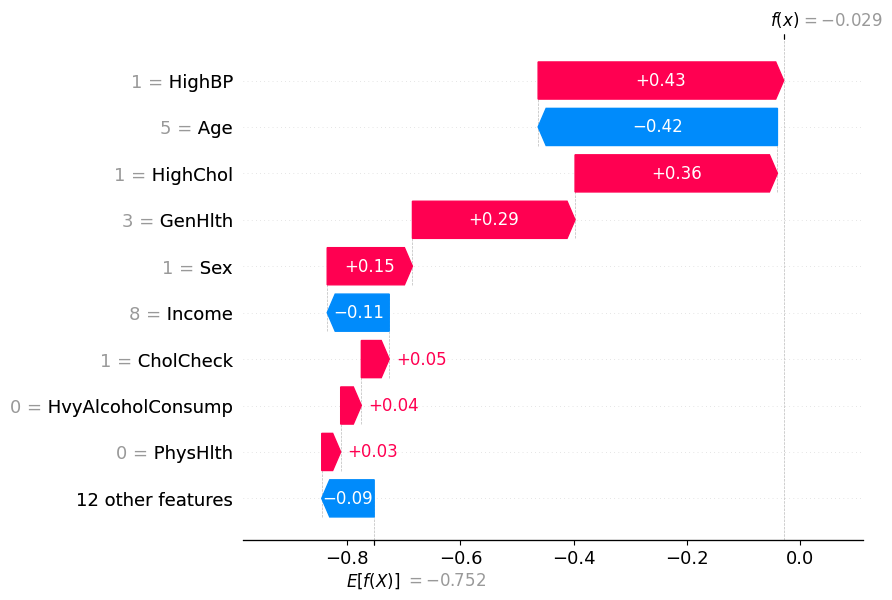

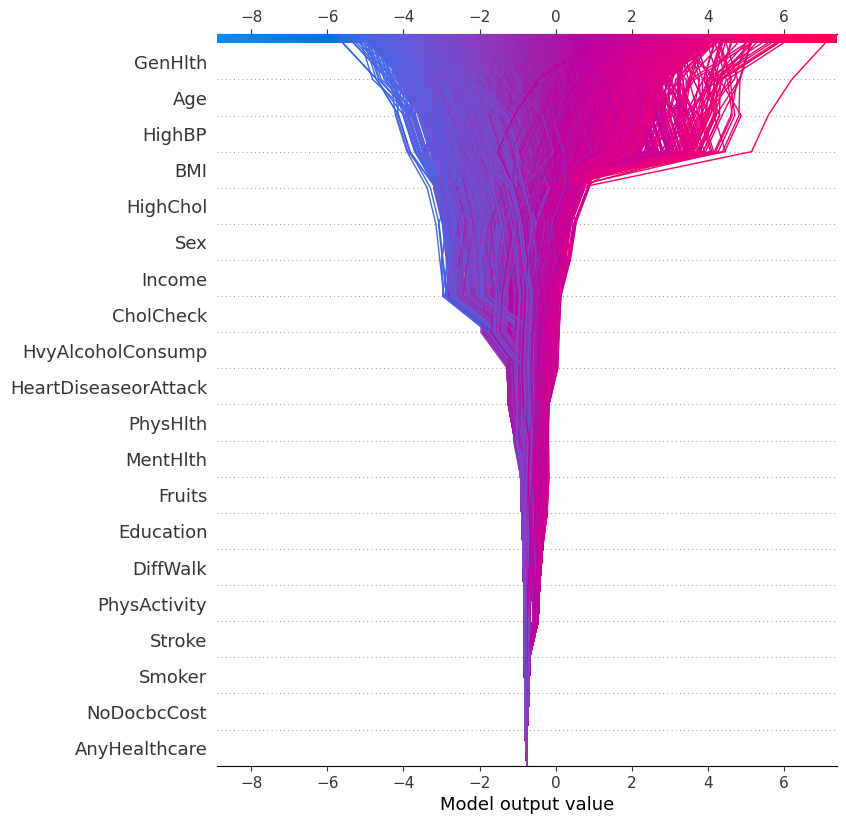

Varianza de los valores SHAP por característica:
GenHlth                 3.927985e-01
BMI                     2.384573e-01
Age                     2.096875e-01
HighBP                  1.324551e-01
HighChol                8.383948e-02
CholCheck               5.317069e-02
HvyAlcoholConsump       2.912578e-02
Sex                     1.602471e-02
Income                  1.480302e-02
HeartDiseaseorAttack    5.563928e-03
PhysHlth                3.495109e-03
MentHlth                3.341878e-03
Stroke                  2.020853e-03
Education               1.443963e-03
Fruits                  1.294137e-03
DiffWalk                1.266337e-03
PhysActivity            5.783865e-04
NoDocbcCost             2.576025e-04
Smoker                  1.515750e-04
AnyHealthcare           1.203790e-04
Veggies                 7.436261e-08
dtype: float64


In [ ]:
# EL FINAL MODEL ES UN + ALL CON LOS PARAMETROS OBTENIDOS EN EL RANDCV

final_pipeline_lr = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', penalty='l2', C=0.1, max_iter=1000))
])

# Entrenar el modelo 
final_pipeline_lr.fit(X_train, y_train)

# Extraer el clasificador final de la pipeline
final_model_lr = final_pipeline_lr.named_steps['clf_lr']

plot_shap(final_model_lr, X_train)


### Final model

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


El umbral óptimo es: 0.59


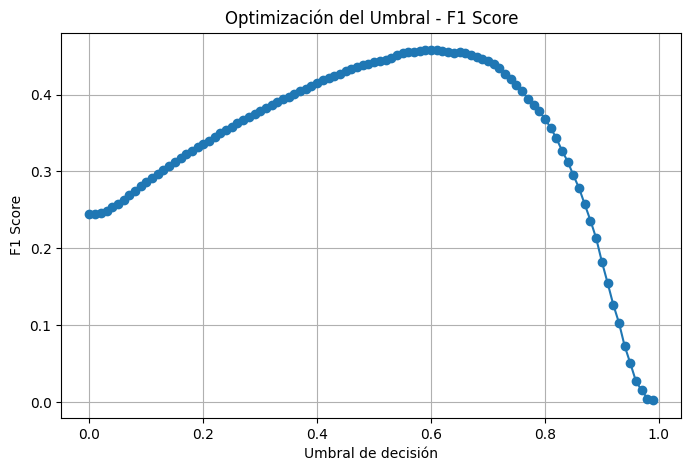

In [85]:
final_pipeline_lr = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', penalty='l2', C=0.1, max_iter=1000))
 ])

optimal_threshold = maximize_f1_score(final_pipeline_lr, X_train, y_train)

In [86]:
final_pipeline_lr = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', penalty='l2', C=0.1, max_iter=1000))
])

start_time = time.time()
final_pipeline_lr.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60

cv_scores = cross_val_score(final_pipeline_lr, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

# Se pasa el valor del umbral óptimo a la función de evaluación para que realice la predicción
# utilizando el umbral ajustado en lugar del valor por defecto (0.5).
metrics_lr_final = evaluate_and_return_metrics(final_pipeline_lr, X_test_filtered, y_test_filtered, execution_time, {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}, cv_scores, threshold=optimal_threshold)

del final_pipeline_lr, start_time, end_time, execution_time, cv_scores, optimal_threshold

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 0.02 minutes
Best Parameters: {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}
Threshold: 0.59
AUC: 0.8187
Accuracy: 0.7810
Recall: 0.6589
Precision: 0.3487
Confusion Matrix:
[[34966  8701]
 [ 2411  4658]]
Cross-Validation AUC: Mean = 0.8228, Std = 0.0029


Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Final Model: Logistic Regression,0.818685,0.780984,0.658933,0.348679,0.822828,0.002907,0.037446


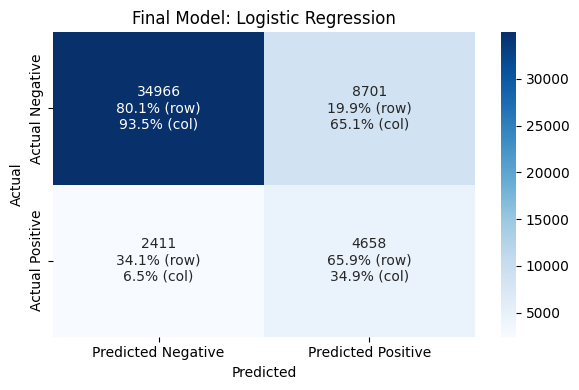

In [ ]:
model_results = [
    {
        "model": "Final Model: Logistic Regression",
        **metrics_final_lr
    }
]
plot_results(model_results)

del model_results

## RandomForestClassifier
Modelo base fuerte, maneja datos categóricos sin problemas y es robusto.

PARAMETROS  EVALUADOS en RandomForestClassifier:
* **n_estimators** (cantidad de árboles): 100 es un buen punto de partida, pero Random Forest suele mejorar hasta ~300-500 árboles antes de volverse ineficiente.
Valores mayores a 500 no suelen mejorar el rendimiento significativamente en datasets medianos/grandes. (Breiman, L. (2001). Random Forests en Machine Learning Journal.)
* **max_depth** (profundidad máxima del árbol): None permite que el árbol crezca completamente (puede sobreajustar).
Valores pequeños (10-20) controlan el overfitting y mejoran la capacidad de generalización.
Más de 30 generalmente es innecesario, ya que la mayoría de los datasets no requieren árboles tan profundos. (Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning.)
* **min_samples_split** (Mínimo de muestras para dividir un nodo): Valores bajos (2-5) permiten que el árbol crezca más profundo y capture más patrones.
Valores más altos (10+) reducen la profundidad del árbol y evitan el sobreajuste. (Scikit-learn documentation: Empirical Studies on Decision Trees.)
* **min_samples_leaf** (Mínimo de muestras en las hojas finales): 1 es el valor predeterminado y permite capturar patrones raros.
2 o 4 evitan ramas muy específicas y reducen el sobreajuste. (Breiman, L. (2001). Random Forests.)
* **max_features** (Número de características consideradas en cada split): sqrt (raíz cuadrada del número total de features) es la configuración estándar en Random Forest.
log2 (logaritmo en base 2 del número total de features) reduce aún más la correlación entre árboles, lo cual puede mejorar estabilidad. (Ho, Tin Kam (1998). Random Decision Forests.)
* **bootstrap** (Uso de muestreo con reemplazo). True (predeterminado) → Cada árbol se entrena con un subconjunto aleatorio del dataset.
False (Sin reemplazo) → Cada árbol usa TODO el dataset. (Breiman, L. (2001). Bagging Predictors.)

### Fase 1: tuning del modelo

#### Combinación 1: RandomizedSearchCV + Undersampling

In [66]:
# Definición del espacio de hiperparámetros para Random Forest
param_distributions_rf = {
    'clf_rf__n_estimators': [100, 300, 500],
    'clf_rf__max_depth': [None, 10, 20, 30, 40],
    'clf_rf__min_samples_split': [2, 5],
    'clf_rf__min_samples_leaf': [1, 2],
    'clf_rf__bootstrap': [True, False]
}

In [67]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_rf', RandomForestClassifier(random_state=42))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_rf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_randcv_un = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Execution time: 21.15 minutes
Best Parameters: {'clf_rf__n_estimators': 300, 'clf_rf__min_samples_split': 5, 'clf_rf__min_samples_leaf': 2, 'clf_rf__max_depth': 10, 'clf_rf__bootstrap': True}
AUC: 0.8202
Accuracy: 0.7130
Recall: 0.7881
Precision: 0.2990
Confusion Matrix:
[[30606 13061]
 [ 1498  5571]]
Cross-Validation AUC: Mean = 0.8247, Std = 0.0030


#### Combinación 2: RandomizedSearchCV + Oversampling

In [68]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf_rf', RandomForestClassifier(random_state=42))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_rf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_randcv_ov = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

KeyboardInterrupt: 

#### Combinación 3: RandomizedSearchCV + class_weight

In [ ]:
pipeline = Pipeline([
    ('clf_rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_rf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_randcv_wght = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

Fitting 10 folds for each of 25 candidates, totalling 250 fits


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Combination 3: RandomizedSearchCV + Undersampling
Best hyperparameters found:
{'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10, 'classifier__bootstrap': True}
Best CV AUC: 0.8244
Total search time: 8.66 minutes

Test set results:
AUC: 0.8198
Accuracy: 0.7131
F1 Score: 0.4341
Recall: 0.7898
Precision: 0.2993
Confusion Matrix:
[[30596 13071]
 [ 1486  5583]]


#### Combinación 4: Optuna + Undersampling

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    pipeline = ImbPipeline([
        ('undersample', RandomUnderSampler(random_state=42)),
        ('clf_rf', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    random_state=42)
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_rf', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_opt_un = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-03-29 09:44:09,411] A new study created in memory with name: no-name-9bc71e83-a73a-4dac-85b5-f3e70fcd2ddb
[I 2025-03-29 09:48:40,841] Trial 0 finished with value: 0.7771372843399619 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7771372843399619.
[I 2025-03-29 09:49:18,591] Trial 1 finished with value: 0.7435190158811718 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7771372843399619.
[I 2025-03-29 09:52:20,676] Trial 2 finished with value: 0.7937904766137983 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.7937904766137983.
[I 2025-03-29 09:54:29,792] Trial 3 finished with value: 0.7952

Combination 4: Optuna + Balanced Weight
Best trial:
FrozenTrial(number=7, state=TrialState.COMPLETE, values=[0.825058922513335], datetime_start=datetime.datetime(2025, 3, 29, 9, 57, 58, 592733), datetime_complete=datetime.datetime(2025, 3, 29, 10, 0, 28, 371984), params={'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True, 'class_weight': 'balanced'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': CategoricalDistribution(choices=(100, 300, 500)), 'max_depth': CategoricalDistribution(choices=(None, 10, 20, 30, 40)), 'min_samples_split': CategoricalDistribution(choices=(2, 5)), 'min_samples_leaf': CategoricalDistribution(choices=(1, 2)), 'bootstrap': CategoricalDistribution(choices=(True, False)), 'class_weight': CategoricalDistribution(choices=('balanced', 'balanced_subsample'))}, trial_id=7, value=None)
Total optimization time: 57.74 minutes

Test set results:
AUC: 0.8205
Accuracy: 0.7251
F1 Scor

#### Combinación 5: Optuna + Oversampling

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf_rf', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    random_state=42)
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf_rf', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_opt_ov = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-03-29 13:01:18,381] A new study created in memory with name: no-name-393b8e4e-9220-4981-81ae-8985e5b8b53e
[I 2025-03-29 13:11:56,778] Trial 0 finished with value: 0.7395980947711214 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 0.7395980947711214.
[I 2025-03-29 13:18:48,808] Trial 1 finished with value: 0.7859497509822078 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 0.7859497509822078.
[I 2025-03-29 13:23:27,750] Trial 2 finished with value: 0.7393282692817182 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 1 with value: 0.7859497509822078.
[I 2025-03-29 13:24:37,563] Trial 3 finished with value: 0.8173773054407579 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_spl

Combination 5: Optuna + Oversampling (SMOTE)
Best trial:
FrozenTrial(number=16, state=TrialState.COMPLETE, values=[0.8175932399846658], datetime_start=datetime.datetime(2025, 3, 29, 13, 56, 5, 967635), datetime_complete=datetime.datetime(2025, 3, 29, 13, 59, 20, 682684), params={'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': CategoricalDistribution(choices=(100, 300, 500)), 'max_depth': CategoricalDistribution(choices=(None, 10, 20, 30, 40)), 'min_samples_split': CategoricalDistribution(choices=(2, 5)), 'min_samples_leaf': CategoricalDistribution(choices=(1, 2)), 'bootstrap': CategoricalDistribution(choices=(True, False))}, trial_id=16, value=None)
Total optimization time: 86.40 minutes


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Test set results:
AUC: 0.8134
Accuracy: 0.7059
F1 Score: 0.4262
Recall: 0.7840
Precision: 0.2926
Confusion Matrix:
[[30271 13396]
 [ 1527  5542]]


#### Combinación 6: Optuna + class_weight

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200, step=50)
    max_depth = trial.suggest_categorical('max_depth', [None, 5, 10, 20])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    pipeline = Pipeline([
        ('clf_rf', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, class_weight='balanced', random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    class_weight='balanced',
    random_state=42)
pipeline = Pipeline([
    ('clf_rf', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv,
                            scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_opt_wght = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered,
                                                  execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-03-29 14:47:05,072] A new study created in memory with name: no-name-e21f7a9b-6037-453f-8507-c0dbc606284d
[I 2025-03-29 14:47:34,352] Trial 0 finished with value: 0.8124142270854623 and parameters: {'n_estimators': 500, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.8124142270854623.
[I 2025-03-29 14:47:59,255] Trial 1 finished with value: 0.8124142270854623 and parameters: {'n_estimators': 500, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.8124142270854623.
[I 2025-03-29 14:48:17,186] Trial 2 finished with value: 0.8246855528281933 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 2 with value: 0.8246855528281933.
[I 2025-03-29 14:48:36,003] Trial 3 finished with value: 0.8011944265045463 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_spli

Combination 6: Optuna + Undersampling
Best trial:
FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.8246855528281933], datetime_start=datetime.datetime(2025, 3, 29, 14, 47, 59, 256978), datetime_complete=datetime.datetime(2025, 3, 29, 14, 48, 17, 186922), params={'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': CategoricalDistribution(choices=(100, 300, 500)), 'max_depth': CategoricalDistribution(choices=(None, 10, 20, 30, 40)), 'min_samples_split': CategoricalDistribution(choices=(2, 5)), 'min_samples_leaf': CategoricalDistribution(choices=(1, 2)), 'bootstrap': CategoricalDistribution(choices=(True, False))}, trial_id=2, value=None)
Total optimization time: 6.62 minutes

Test set results:
AUC: 0.8202
Accuracy: 0.7148
F1 Score: 0.4350
Recall: 0.7882
Precision: 0.3004
Confusion Matrix:
[[30692 12975]
 [ 1497  5572]]


#### Resumen y conclusiones
Si bien la combinación Optuna + Balanced Weight ofrecía el AUC más alto, la combinación Optuna + Undersampling se definió como la preferida por su relativa rapidez de cómputo y un AUC que, si bien es algo menor, sigue siendo competitivo (por encima de 0.81). Es por ello que **se va a emplear la combinación Optuna-Undersampling** para el resto de los modelos (aunque sabemos que no se debería asumir que es la mejor combinación para todos los modelos).

* El **AUC** de **0.8202** indica que el modelo tiene una buena capacidad para discriminar entre los pacientes saludables y los prediabéticos/diabéticos.

* Una **accuracy** revela que el **71.48%** de las predicciones del modelo son correctas (verdaderos positivos y verdaderos negativos).

* El **recall**  revela que el modelo identifica correctamente casi **79 de cada 10** casos positivos.

* La **precision** ndica que de todos los casos clasificados como positivos, solo el **30.04%** son realmente positivos.

* De la **matriz de confusión** se observa que:

    * Falsos positivos: 12,975 casos fueron clasificados erróneamente como positivos cuando en realidad eran negativos.

    * Falsos negativos: 1,497 casos no fueron detectados, lo que está en línea con el recall obtenido.

Esta distribución confirma que el modelo tiende a favorecer la detección de positivos (alto recall), lo que es beneficioso en aplicaciones clínicas donde se prefiere errar en exceso hacia falsos positivos en lugar de perder casos verdaderamente positivos.

La optimización con Optuna utilizando undersampling se completó en solo **6.62 minutos**, lo que es muy eficiente comparado con otras estrategias.

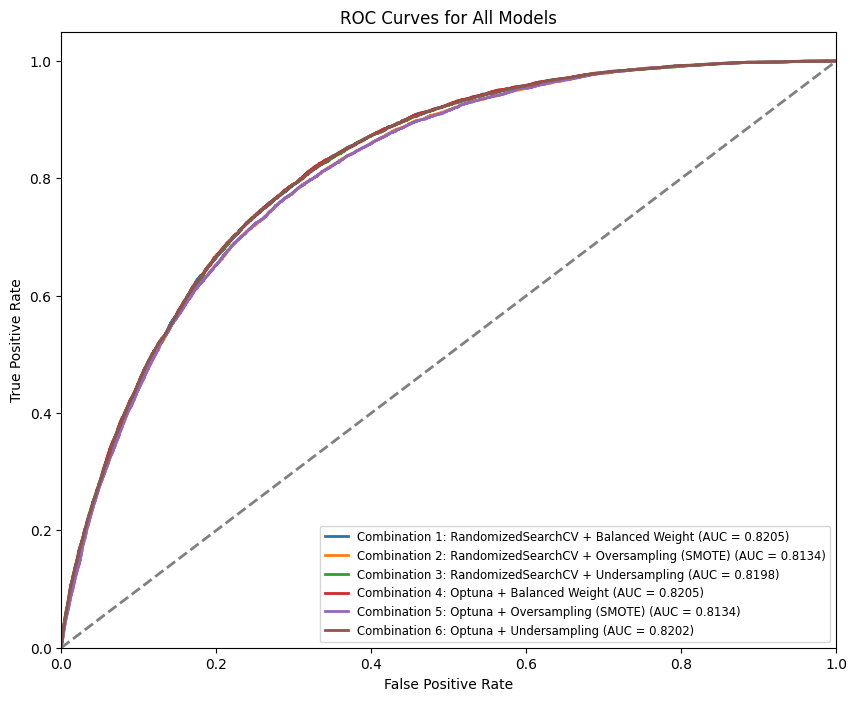

Summary Table:


,Model,AUC,Accuracy,F1 Score,Recall,Precision,Execution Time (minutes)
0,Combination 1: RandomizedSearchCV + Balanced Weight,0.820458,0.725225,0.438655,0.770547,0.306597,65.157761
1,Combination 2: RandomizedSearchCV + Oversampling (SMOTE),0.813402,0.705160,0.425956,0.785118,0.292259,118.331002
2,Combination 3: RandomizedSearchCV + Undersampling,0.819767,0.713083,0.434086,0.789786,0.299292,8.657308
3,Combination 4: Optuna + Balanced Weight,0.820475,0.725067,0.439326,0.773094,0.306850,57.737785
4,Combination 5: Optuna + Oversampling (SMOTE),0.813370,0.705870,0.426193,0.783986,0.292639,86.398656
5,Combination 6: Optuna + Undersampling,0.820157,0.714759,0.435041,0.788230,0.300426,6.619149


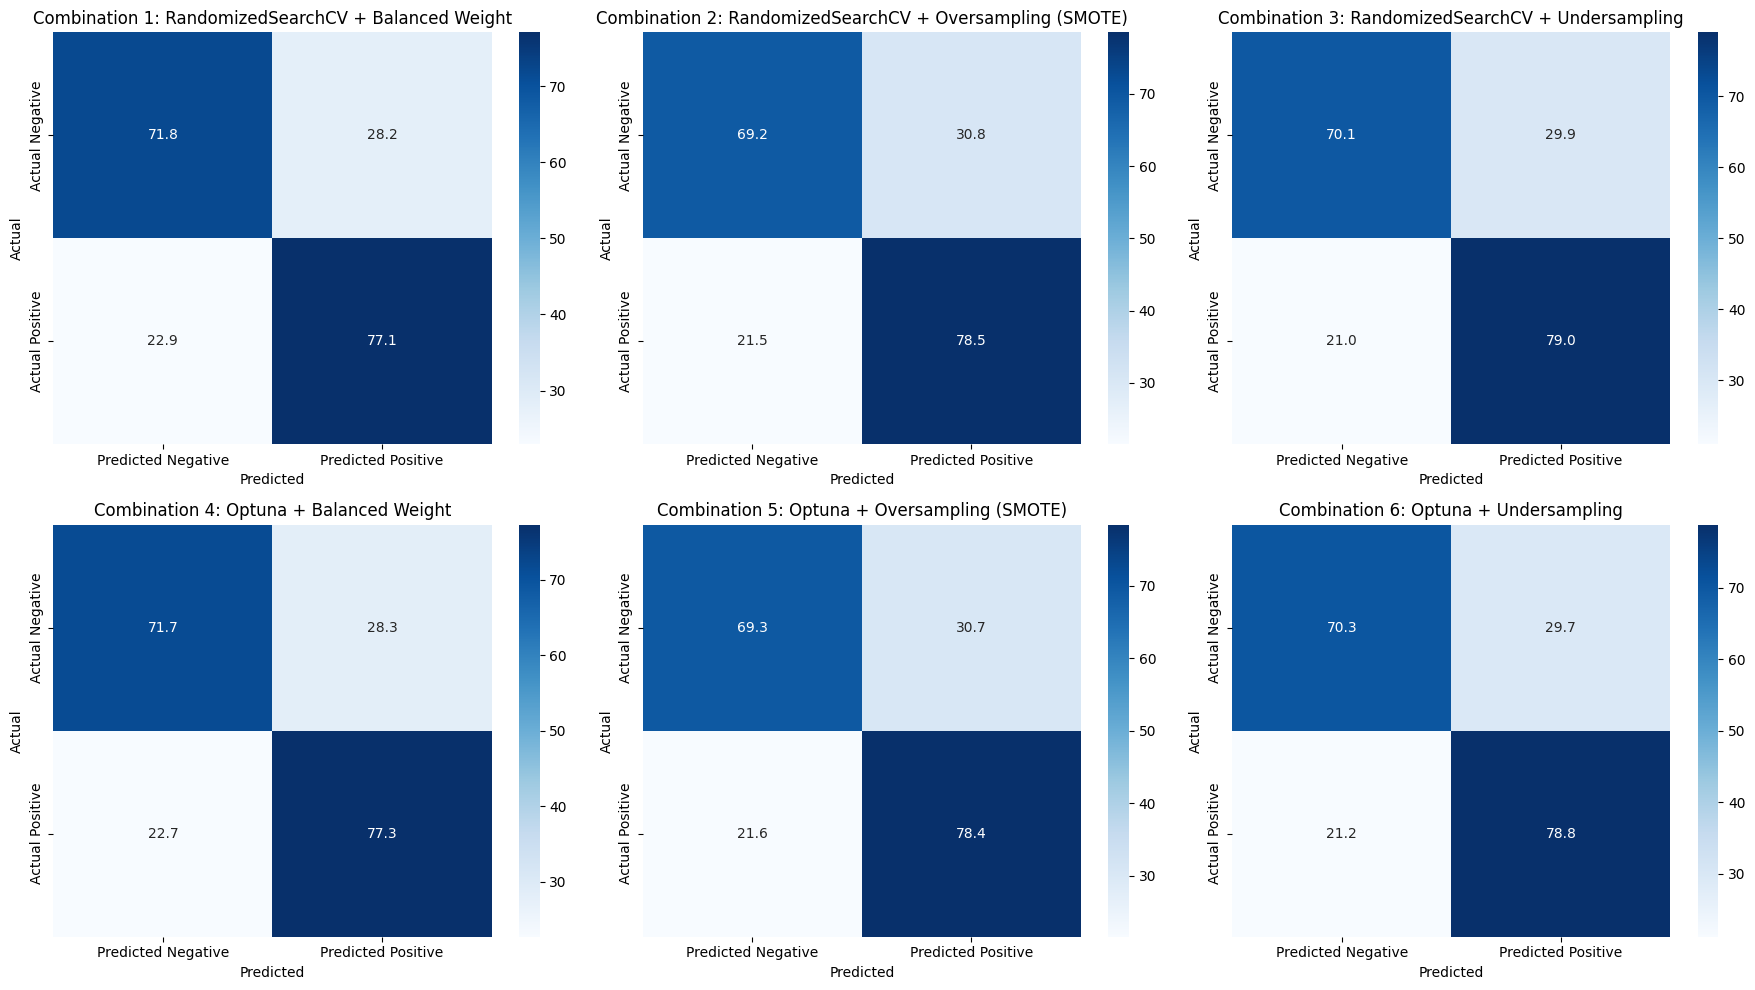

In [ ]:
model_results = [
    {
        "model": "Combination 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Combination 1: RandomizedSearchCV + Undersampling",
        **metrics_rf_randcv_un
    },
    {
        "model": "Combination 2: RandomizedSearchCV + Oversampling",
        **metrics_rf_randcv_ov
    },
    {
        "model": "Combination 3: RandomizedSearchCV + class_weight",
        **metrics_rf_randcv_wght
    },
    {
        "model": "Combination 4: Optuna + Undersampling",
        **metrics_rf_opt_un
    },
    {
        "model": "Combination 5: Optuna + Oversampling",
        **metrics_rf_opt_ov
    },
    {
        "model": "Combination 6: Optuna + class_weight",
        **metrics_rf_opt_wght
    }
]

plot_results(model_results)

In [ ]:
cv_scores = {
    'Combination 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Combination 1: RandCV + Un': metrics_rf_randcv_un['cv_scores'],
    'Combination 2: RandCV + Ov': metrics_rf_randcv_ov['cv_scores'],
    'Combination 3: RandCV + wght': metrics_rf_randcv_wght['cv_scores'],
    'Combination 4: Opt + Un': metrics_rf_opt_un['cv_scores'],
    'Combination 5: Opt + Ov': metrics_rf_opt_ov['cv_scores'],
    'Combination 6: Opt + wght': metrics_rf_opt_wght['cv_scores']
}

perform_stat_tests(cv_scores)

del cv_scores



---
Nota

---

Aunque no se ha implementado validación cruzada anidada (nested cross-validation) debido a su alto coste computacional, se ha utilizado una combinación de validación cruzada estratificada de 10 particiones y conjunto de test externo para garantizar una evaluación robusta del modelo, tal como se exige en la práctica. Esta estrategia ofrece una estimación fiable del rendimiento sin requerir los recursos computacionales adicionales que implicaría la anidación.

### Fase 2: tuning de los datos

#### Configuración 1: variables seleccionadas manualmente

In [ ]:
metrics_rf_man_sel = metrics_rf_randcv_un

#### Configuración 2: variables seleccionadas automáticamente

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    ('clf_rf', RandomForestClassifier(random_state=42))
])

param_distributions_sfm = {
    'selector__estimator__n_estimators': [50, 100, 150],
    'selector__threshold': ['mean', 'median', 0.01, 0.05],
    'clf_rf__n_estimators': [50, 100, 150, 200],
    'clf_rf__max_depth': [None, 5, 10, 20]
}

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions=param_distributions_sfm, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(pipeline, X_test, y_test, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_aut_sel = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

selected_features = X_train.columns[best_model.named_steps['selector'].get_support()].tolist()
print("Variables seleccionadas:", selected_features)

del pipeline, param_distributions_sfm, start_time, search, end_time, execution_time, best_model, cv_scores, selected_features

#### Configuración 3: reducción de la dimensionalidad

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('umap', umap.UMAP(random_state=42)),
    ('clf_rf', RandomForestClassifier(random_state=42))
])

param_distributions_umap = {
    'umap__n_components': [3, 5, 7, 10],
    'umap__n_neighbors': [5, 10, 15, 30],
    'umap__min_dist': [0.0, 0.1, 0.2, 0.3],
    'clf_rf__n_estimators': [50, 100, 150, 200],
    'clf_rf__max_depth': [None, 5, 10, 20]
}

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions=param_distributions_umap, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(pipeline, X_test, y_test, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_red_dim = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, param_distributions_umap, start_time, search, end_time, execution_time, best_model, cv_scores

#### Configuración 4: todas las variables

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_rf', RandomForestClassifier(random_state=42))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_rf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_all = evaluate_and_return_metrics(best_model, X_train, y_train, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

#### Resumen y conclusiones

In [ ]:
model_results = [
    {
        "model": "Configuration 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Configuration 1: Variables seleccionadas manualmente",
        **metrics_rf_man_sel
    },
    {
        "model": "Configuration 2: Variables seleccionadas automáticamente",
        **metrics_rf_aut_sel
    },
    {
        "model": "Configuration 3: reducción de dimensionalidad",
        **metrics_rf_red_dim
    },
    {
        "model": "Configuration 4: todas las variables",
        **metrics_rf_all
    }
]

plot_results(model_results)

In [ ]:
cv_scores = {
    'Configuration 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Configuration 1: man_sel': metrics_rf_man_sel['cv_scores'],
    'Configuration 2: aut_sel': metrics_rf_aut_sel['cv_scores'],
    'Configuration 3: red_dim': metrics_rf_red_dim['cv_scores'],
    'Configuration 4: all': metrics_rf_all['cv_scores']
}

perform_stat_tests(cv_scores)

In [ ]:
# Entrenamiento de un modelo Random Forest para SHAP
#modelo = RandomForestClassifier(random_state=42)
#modelo.fit(X_train, y_train)

# Inicialización del explainer para modelos basados en árboles
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(X_test)

# 1. Force plot para explicar una predicción individual (por ejemplo, la primera instancia del test)
shap.initjs()  # Inicializa la visualización interactiva (en entornos compatibles como Jupyter)
force_plot = shap.force_plot(explainer.expected_value[1], shap_values[1][0, :], X_test.iloc[0, :])
# Para visualizar en Jupyter: display(force_plot)

# 2. Summary plot para ver la importancia global de las características
shap.summary_plot(shap_values[1], X_test)

# 3. Dependence plot para analizar el efecto de una característica específica
feature_name = X.columns[0]
shap.dependence_plot(feature_name, shap_values[1], X_test)

## LightGBM
Más rápido y eficiente que GradientBoostingClassifier, ideal para datasets grandes.

### Fase 1: tuning del modelo

#### Combinación 1: RandomizedSearchCV + Undersampling

In [ ]:
param_distributions_lgb = {
    'clf_lgb__n_estimators': [100, 300, 500],
    'clf_lgb__max_depth': [-1, 10, 20, 30, 40],
    'clf_lgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'clf_lgb__num_leaves': [20, 31, 40, 50],
    'clf_lgb__min_child_samples': [5, 10, 20],
    'clf_lgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_lgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_lgb__reg_alpha': [0.0, 0.5, 1.0],
    'clf_lgb__reg_lambda': [0.0, 0.5, 1.0]
}

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lgb', lgb.LGBMClassifier(random_state=42))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_lgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_randcv_un = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores


#### Combination 2: RandomizedSearchCV + Oversampling

In [ ]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf_lgb', lgb.LGBMClassifier(random_state=42))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_lgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_randcv_ov = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

#### Combination 3: RandomizedSearchCV + class_weight

In [ ]:
pipeline = Pipeline([
    ('clf_lgb', lgb.LGBMClassifier(random_state=42, class_weight='balanced'))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_lgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_randcv_wght = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

#### Combination 4: Optuna + Undersampling

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [-1, 10, 20, 30, 40])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5, log=True)
    num_leaves = trial.suggest_categorical('num_leaves', [20, 31, 40, 50])
    min_child_samples = trial.suggest_categorical('min_child_samples', [5, 10, 20])
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)
    
    pipeline = ImbPipeline([
        ('undersample', RandomUnderSampler(random_state=42)),
        ('clf_lgb', lgb.LGBMClassifier( n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = lgb.LGBMClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    num_leaves=best_params['num_leaves'],
    min_child_samples=best_params['min_child_samples'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42)
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lgb', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_opt_un = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

#### Combinación 5: Optuna + Oversampling

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [-1, 10, 20, 30, 40])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5, log=True)
    num_leaves = trial.suggest_categorical('num_leaves', [20, 31, 40, 50])
    min_child_samples = trial.suggest_categorical('min_child_samples', [5, 10, 20])
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)
    
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf_lgb', lgb.LGBMClassifier( n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = lgb.LGBMClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    num_leaves=best_params['num_leaves'],
    min_child_samples=best_params['min_child_samples'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42)
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf_lgb', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_opt_ov = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

#### Combinación 6: Optuna + class_weight

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [-1, 10, 20, 30, 40])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5, log=True)
    num_leaves = trial.suggest_categorical('num_leaves', [20, 31, 40, 50])
    min_child_samples = trial.suggest_categorical('min_child_samples', [5, 10, 20])
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)
    
    pipeline = Pipeline([
        ('clf_lgb', lgb.LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, reg_lambda=reg_lambda, class_weight='balanced', random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = lgb.LGBMClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    num_leaves=best_params['num_leaves'],
    min_child_samples=best_params['min_child_samples'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    class_weight='balanced',
    random_state=42)
pipeline = Pipeline([
    ('clf_lgb', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_opt_wght = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

#### Resultados y conclusiones

In [ ]:
model_results = [
    {
        "model": "Combination 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Combination 1: RandomizedSearchCV + Undersampling",
        **metrics_lgb_randcv_un
    },
    {
        "model": "Combination 2: RandomizedSearchCV + Oversampling",
        **metrics_lgb_randcv_ov
    },
    {
        "model": "Combination 3: RandomizedSearchCV + class_weight",
        **metrics_lgb_randcv_wght
    },
    {
        "model": "Combination 4: Optuna + Undersampling",
        **metrics_lgb_opt_un
    },
    {
        "model": "Combination 5: Optuna + Oversampling",
        **metrics_lgb_opt_ov
    },
    {
        "model": "Combination 6: Optuna + class_weight",
        **metrics_lgb_opt_wght
    }
]

plot_results(model_results)

In [ ]:
cv_scores = {
    'Combination 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Combination 1: RandCV + Un': metrics_lgb_randcv_un['cv_scores'],
    'Combination 2: RandCV + Ov': metrics_lgb_randcv_ov['cv_scores'],
    'Combination 3: RandCV + wght': metrics_lgb_randcv_wght['cv_scores'],
    'Combination 4: Opt + Un': metrics_lgb_opt_un['cv_scores'],
    'Combination 5: Opt + Ov': metrics_lgb_opt_ov['cv_scores'],
    'Combination 6: Opt + wght': metrics_lgb_opt_wght['cv_scores']
}

perform_stat_tests(cv_scores)

del cv_scores

### Fase 2: tuning de los datos

#### Configuración 1: variables seleccionadas manualmente

In [ ]:
metrics_lgb_man_sel = metrics_lgb_randcv_un

#### Configuración 2: variables seleccionadas automáticamente

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(lgb.LGBMClassifier(n_estimators=100, random_state=42))),
    ('clf_lgb', lgb.LGBMClassifier(random_state=42))
])

param_distributions_sfm = {
    'selector__estimator__n_estimators': [100, 300, 500],
    'selector__threshold': ['mean', 'median', 0.01, 0.05],
    'clf_lgb__n_estimators': [100, 300, 500],
    'clf_lgb__max_depth': [-1, 10, 20, 30, 40]
}

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions=param_distributions_sfm, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(pipeline, X_test, y_test, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_aut_sel = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

selected_features = X_train.columns[best_model.named_steps['selector'].get_support()].tolist()
print("Variables seleccionadas:", selected_features)

del pipeline, param_distributions_sfm, start_time, search, end_time, execution_time, best_model, cv_scores, selected_features

#### Combinación 3: reducción de dimensionalidad

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('umap', umap.UMAP(random_state=42)),
    ('clf_lgb', lgb.LGBMClassifier(random_state=42))
])

param_distributions_umap = {
    'umap__n_components': [3, 5, 7, 10],
    'umap__n_neighbors': [5, 10, 15, 30],
    'umap__min_dist': [0.0, 0.1, 0.2, 0.3],
    'clf_lgb__n_estimators': [100, 300, 500],
    'clf_lgb__max_depth': [-1, 10, 20, 30, 40]
}

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions=param_distributions_umap, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(pipeline, X_test, y_test, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_red_dim = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, param_distributions_umap, start_time, search, end_time, execution_time, best_model, cv_scores

#### Combinación 4: todas las variables

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lgb', lgb.LGBMClassifier(random_state=42))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_lgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_all = evaluate_and_return_metrics(best_model, X_train, y_train, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

#### Resumen y conclusiones

In [ ]:
model_results = [
    {
        "model": "Configuration 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Configuration 1: Variables seleccionadas manualmente",
        **metrics_lgb_man_sel
    },
    {
        "model": "Configuration 2: Variables seleccionadas automáticamente",
        **metrics_lgb_aut_sel
    },
    {
        "model": "Configuration 3: reducción de dimensionalidad",
        **metrics_lgb_red_dim
    },
    {
        "model": "Configuration 4: todas las variables",
        **metrics_lgb_all
    }
]

plot_results(model_results)

In [ ]:
cv_scores = {
    'Configuration 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Configuration 1: man_sel': metrics_lgb_man_sel['cv_scores'],
    'Configuration 2: aut_sel': metrics_lgb_aut_sel['cv_scores'],
    'Configuration 3: red_dim': metrics_lgb_red_dim['cv_scores'],
    'Configuration 4: all': metrics_lgb_all['cv_scores']
}

perform_stat_tests(cv_scores)

In [ ]:
# Entrenamiento de un modelo LightGBM para interpretación
#modelo = lgb.LGBMClassifier(random_state=42)
#modelo.fit(X_train, y_train)

# Inicialización del explainer para modelos basados en árboles
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(X_test)

# 1. Force plot para explicar una predicción individual (por ejemplo, la primera instancia del test)
shap.initjs()  # Inicializa la visualización interactiva (compatible con Jupyter)
force_plot = shap.force_plot(explainer.expected_value[1], shap_values[1][0, :], X_test.iloc[0, :])
# Para visualizar en Jupyter: display(force_plot)

# 2. Summary plot para ver la importancia global de las características
shap.summary_plot(shap_values[1], X_test)

# 3. Dependence plot para analizar el efecto de una característica específica
feature_name = X.columns[0]
shap.dependence_plot(feature_name, shap_values[1], X_test)

## CatBoost
Maneja mejor variables categóricas sin necesidad de preprocesamiento extra.

### Modelo 1

In [12]:
def objective_catboost_1(trial):
    # Definir el espacio de hiperparámetros para CatBoost
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    depth = trial.suggest_categorical('depth', [3, 5, 7, 10, 15])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5, log=True)
    random_strength = trial.suggest_float('random_strength', 0.0, 1.0)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0.0, 1.0)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1.0, 10.0)
    border_count = trial.suggest_categorical('border_count', [32, 50, 100])

    # Crear el pipeline que integra undersampling y CatBoost
    pipeline_catboost_1 = Pipeline([
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', CatBoostClassifier(
            iterations=n_estimators,  # En CatBoost se usa 'iterations' en lugar de n_estimators
            depth=depth,
            learning_rate=learning_rate,
            random_strength=random_strength,
            bagging_temperature=bagging_temperature,
            l2_leaf_reg=l2_leaf_reg,
            border_count=border_count,
            random_seed=42,
            thread_count=n_jobs,
            verbose=False
        ))
    ])

    cv_strategy_catboost_1 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    # Validación cruzada automática con cross_val_score usando la métrica AUC
    scores = cross_val_score(pipeline_catboost_1, X_train, y_train, cv=cv_strategy_catboost_1, scoring='roc_auc', n_jobs=n_jobs)
    return np.mean(scores)

start_time_optuna_catboost_1 = time.time()
study_catboost_1 = optuna.create_study(direction='maximize')
study_catboost_1.optimize(objective_catboost_1, n_trials=200)
end_time_optuna_catboost_1 = time.time()
execution_time_optuna_catboost_1 = (end_time_optuna_catboost_1 - start_time_optuna_catboost_1) / 60

print("Combination CatBoost 1: Optuna + Undersampling")
print("Best trial:")
print(study_catboost_1.best_trial)
print("Total optimization time: {:.2f} minutes".format(execution_time_optuna_catboost_1))

# Construir el modelo final con los mejores parámetros y evaluar en X_test
best_params_catboost_1 = study_catboost_1.best_trial.params

pipeline_catboost_1 = Pipeline([
    ('sampling', RandomUnderSampler(random_state=42)),
    ('classifier', CatBoostClassifier(
        iterations=best_params_catboost_1['n_estimators'],
        depth=best_params_catboost_1['depth'],
        learning_rate=best_params_catboost_1['learning_rate'],
        random_strength=best_params_catboost_1['random_strength'],
        bagging_temperature=best_params_catboost_1['bagging_temperature'],
        l2_leaf_reg=best_params_catboost_1['l2_leaf_reg'],
        border_count=best_params_catboost_1['border_count'],
        random_seed=42,
        thread_count=n_jobs,
        verbose=False
    ))
])

pipeline_catboost_1.fit(X_train, y_train)

y_pred_proba_catboost_1 = pipeline_catboost_1.predict_proba(X_test)[:, 1]
y_pred_catboost_1 = pipeline_catboost_1.predict(X_test)

auc_catboost_1 = roc_auc_score(y_test, y_pred_proba_catboost_1)
accuracy_catboost_1 = accuracy_score(y_test, y_pred_catboost_1)
f1_catboost_1 = f1_score(y_test, y_pred_catboost_1)
recall_catboost_1 = recall_score(y_test, y_pred_catboost_1)
precision_catboost_1 = precision_score(y_test, y_pred_catboost_1)
conf_matrix_catboost_1 = confusion_matrix(y_test, y_pred_catboost_1)

print("\nTest set results for CatBoost (Optuna + Undersampling):")
print("AUC: {:.4f}".format(auc_catboost_1))
print("Accuracy: {:.4f}".format(accuracy_catboost_1))
print("F1 Score: {:.4f}".format(f1_catboost_1))
print("Recall: {:.4f}".format(recall_catboost_1))
print("Precision: {:.4f}".format(precision_catboost_1))
print("Confusion Matrix:")
print(conf_matrix_catboost_1)

[I 2025-04-01 09:58:35,870] A new study created in memory with name: no-name-da8365ca-48d8-4ae5-9cbf-032945305e06
[I 2025-04-01 09:58:57,054] Trial 0 finished with value: 0.8274748637399281 and parameters: {'n_estimators': 300, 'depth': 3, 'learning_rate': 0.07873755300592686, 'random_strength': 0.6036699765407351, 'bagging_temperature': 0.8523525854839379, 'l2_leaf_reg': 3.0121644990507894, 'border_count': 50}. Best is trial 0 with value: 0.8274748637399281.
[I 2025-04-01 09:59:11,742] Trial 1 finished with value: 0.822455837307168 and parameters: {'n_estimators': 300, 'depth': 7, 'learning_rate': 0.0036375876736045353, 'random_strength': 0.4772709523968085, 'bagging_temperature': 0.8505450252322391, 'l2_leaf_reg': 1.2832111343865316, 'border_count': 32}. Best is trial 0 with value: 0.8274748637399281.
[I 2025-04-01 09:59:20,444] Trial 2 finished with value: 0.8263800015751428 and parameters: {'n_estimators': 100, 'depth': 10, 'learning_rate': 0.031851870687002494, 'random_strength': 

KeyboardInterrupt: 

se paró la ejecución por la lentitud del modelo (23 trials en más de 2h) al observar que algunos trials tardaban demasiado en ejecutarse. Posiblemente se deba a complejas combinaciones de hiperparámetros que ralentizan la ejecución.

para solucionarlo, se va a implementar un pruner en Optuna que permite detener de forma temprana aquellos trials que no muestran un buen rendimiento.

### Modelo 2

* Se reemplaza el uso de cross_val_score por un bucle manual que itera sobre cada fold definido por StratifiedKFold.

* En cada iteración se entrena el pipeline (que incluye RandomUnderSampler y CatBoostClassifier) en el conjunto de entrenamiento del fold y se evalúa el AUC en el conjunto de validación.

* Con trial.report(score, step=fold) se informa a Optuna del rendimiento parcial, y se utiliza trial.should_prune() para interrumpir el trial si el desempeño intermedio es insatisfactorio.

* Se crea el estudio de Optuna utilizando el MedianPruner, lo que permite detener trials no prometedores y ahorrar tiempo de cómputo.

* Se optó por utilizar el MedianPruner debido a varias razones, entre ellas porque evalúa el rendimiento de cada trial comparando la métrica parcial (el AUC en cada fold) con la mediana de los resultados obtenidos en los trials completados hasta ese momento. Esto permite identificar de manera sencilla y robusta aquellos trials que se desempeñan por debajo del rendimiento esperado.

In [15]:
def objective_catboost_2(trial):
    # Definir el espacio de hiperparámetros para CatBoost
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    depth = trial.suggest_categorical('depth', [3, 5, 7, 10, 15])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5, log=True)
    random_strength = trial.suggest_float('random_strength', 0.0, 1.0)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0.0, 1.0)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1.0, 10.0)
    border_count = trial.suggest_categorical('border_count', [32, 50, 100])
    
    cv_strategy_catboost_2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_scores = []
    
    # Bucle manual de validación cruzada para poder reportar el desempeño por fold
    for fold, (train_idx, valid_idx) in enumerate(cv_strategy_catboost_2.split(X_train, y_train)):
        # Crear el pipeline para el fold actual
        pipeline_catboost_2 = Pipeline([
            ('sampling', RandomUnderSampler(random_state=42)),
            ('classifier', CatBoostClassifier(
                iterations=n_estimators,
                depth=depth,
                learning_rate=learning_rate,
                random_strength=random_strength,
                bagging_temperature=bagging_temperature,
                l2_leaf_reg=l2_leaf_reg,
                border_count=border_count,
                random_seed=42,
                thread_count=n_jobs,
                verbose=False
            ))
        ])
        
        # Utilizar .iloc para indexar las filas por posición
        X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
        pipeline_catboost_2.fit(X_tr, y_tr)
        y_val_pred_proba = pipeline_catboost_2.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_val_pred_proba)
        fold_scores.append(score)
        
        trial.report(score, step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(fold_scores)

start_time_optuna_catboost_2 = time.time()
# Crear el estudio incorporando el MedianPruner
study_catboost_2 = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0))
study_catboost_2.optimize(objective_catboost_2, n_trials=200)
end_time_optuna_catboost_2 = time.time()
execution_time_optuna_catboost_2 = (end_time_optuna_catboost_2 - start_time_optuna_catboost_2) / 60

print("Combination CatBoost 2: Optuna + Undersampling")
print("Best trial:")
print(study_catboost_2.best_trial)
print("Total optimization time: {:.2f} minutes".format(execution_time_optuna_catboost_2))

# Construir el modelo final con los mejores parámetros y evaluar en X_test
best_params_catboost_2 = study_catboost_2.best_trial.params

pipeline_catboost_2 = Pipeline([
    ('sampling', RandomUnderSampler(random_state=42)),
    ('classifier', CatBoostClassifier(
        iterations=best_params_catboost_2['n_estimators'],
        depth=best_params_catboost_2['depth'],
        learning_rate=best_params_catboost_2['learning_rate'],
        random_strength=best_params_catboost_2['random_strength'],
        bagging_temperature=best_params_catboost_2['bagging_temperature'],
        l2_leaf_reg=best_params_catboost_2['l2_leaf_reg'],
        border_count=best_params_catboost_2['border_count'],
        random_seed=42,
        thread_count=n_jobs,
        verbose=False
    ))
])

pipeline_catboost_2.fit(X_train, y_train)

y_pred_proba_catboost_2 = pipeline_catboost_2.predict_proba(X_test)[:, 1]
y_pred_catboost_2 = pipeline_catboost_2.predict(X_test)

auc_catboost_2 = roc_auc_score(y_test, y_pred_proba_catboost_2)
accuracy_catboost_2 = accuracy_score(y_test, y_pred_catboost_2)
f1_catboost_2 = f1_score(y_test, y_pred_catboost_2)
recall_catboost_2 = recall_score(y_test, y_pred_catboost_2)
precision_catboost_2 = precision_score(y_test, y_pred_catboost_2)
conf_matrix_catboost_2 = confusion_matrix(y_test, y_pred_catboost_2)

print("\nTest set results for CatBoost (Optuna + Undersampling):")
print("AUC: {:.4f}".format(auc_catboost_2))
print("Accuracy: {:.4f}".format(accuracy_catboost_2))
print("F1 Score: {:.4f}".format(f1_catboost_2))
print("Recall: {:.4f}".format(recall_catboost_2))
print("Precision: {:.4f}".format(precision_catboost_2))
print("Confusion Matrix:")
print(conf_matrix_catboost_2)

[I 2025-04-01 12:40:20,782] A new study created in memory with name: no-name-aa64e37d-9a2b-41c2-93a5-2bee5974342d
[I 2025-04-01 12:40:55,131] Trial 0 finished with value: 0.8266733554528329 and parameters: {'n_estimators': 100, 'depth': 10, 'learning_rate': 0.049661136551268185, 'random_strength': 0.8464933635666964, 'bagging_temperature': 0.8554142691343968, 'l2_leaf_reg': 5.876203496632104, 'border_count': 50}. Best is trial 0 with value: 0.8266733554528329.
[W 2025-04-01 13:00:27,119] Trial 1 failed with parameters: {'n_estimators': 300, 'depth': 15, 'learning_rate': 0.4450529379334343, 'random_strength': 0.3449096817313284, 'bagging_temperature': 0.14170144375920468, 'l2_leaf_reg': 4.831177935981171, 'border_count': 32} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "

KeyboardInterrupt: 

el trial 0 estuvo más de 20 minutos ejecutándose.

se va a proceder a implementar early stopping

### Modelo 3

La incorporación de early stopping en el entrenamiento de CatBoost es fundamental por varias razones:

* Ahorro de tiempo de cómputo: Dado que cada trial del proceso de validación cruzada implica entrenar el modelo en múltiples folds, early stopping permite interrumpir entrenamientos que no están mostrando mejoras significativas. Esto reduce el tiempo invertido en configuraciones poco prometedoras, optimizando el uso de recursos.

* Prevención del sobreajuste: Al detener el entrenamiento una vez que el rendimiento en el conjunto de validación deja de mejorar, se evita que el modelo se ajuste en exceso a los datos de entrenamiento. Esto es especialmente relevante en escenarios con datos desbalanceados.

* Eficiencia en la optimización: En combinación con la poda de trials (pruning) de Optuna, early stopping permite identificar rápidamente combinaciones de hiperparámetros ineficientes, concentrando la búsqueda en configuraciones que realmente tienen potencial para mejorar el rendimiento del modelo.

In [16]:
def objective_catboost_3(trial):
    # Definir el espacio de hiperparámetros para CatBoost
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    depth = trial.suggest_categorical('depth', [3, 5, 7, 10, 15])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5, log=True)
    random_strength = trial.suggest_float('random_strength', 0.0, 1.0)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0.0, 1.0)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1.0, 10.0)
    border_count = trial.suggest_categorical('border_count', [32, 50, 100])
    
    cv_strategy_catboost_3 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_scores = []
    
    # Bucle manual de validación cruzada para poder reportar el desempeño por fold
    for fold, (train_idx, valid_idx) in enumerate(cv_strategy_catboost_3.split(X_train, y_train)):
        # Crear el pipeline para el fold actual
        pipeline_catboost_3 = Pipeline([
            ('sampling', RandomUnderSampler(random_state=42)),
            ('classifier', CatBoostClassifier(
                iterations=n_estimators,  # En CatBoost se usa 'iterations' en lugar de n_estimators
                depth=depth,
                learning_rate=learning_rate,
                random_strength=random_strength,
                bagging_temperature=bagging_temperature,
                l2_leaf_reg=l2_leaf_reg,
                border_count=border_count,
                random_seed=42,
                thread_count=n_jobs,
                verbose=False
            ))
        ])
        
        # Utilizar .iloc para indexar las filas por posición
        X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
        
        # Entrenar con early stopping: se detiene si no hay mejora en 50 iteraciones
        pipeline_catboost_3.fit(X_tr, y_tr, 
                                classifier__eval_set=[(X_val, y_val)], 
                                classifier__early_stopping_rounds=50)
        
        y_val_pred_proba = pipeline_catboost_3.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_val_pred_proba)
        fold_scores.append(score)
        
        # Reportar el desempeño del fold para permitir la poda del trial
        trial.report(score, step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(fold_scores)

start_time_optuna_catboost_3 = time.time()
# Crear el estudio incorporando el MedianPruner
study_catboost_3 = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0))
study_catboost_3.optimize(objective_catboost_3, n_trials=200)
end_time_optuna_catboost_3 = time.time()
execution_time_optuna_catboost_3 = (end_time_optuna_catboost_3 - start_time_optuna_catboost_3) / 60

print("Combination CatBoost 3: Optuna + Undersampling")
print("Best trial:")
print(study_catboost_3.best_trial)
print("Total optimization time: {:.2f} minutes".format(execution_time_optuna_catboost_3))

# Construir el modelo final con los mejores parámetros y evaluar en X_test
best_params_catboost_3 = study_catboost_3.best_trial.params

pipeline_catboost_3 = Pipeline([
    ('sampling', RandomUnderSampler(random_state=42)),
    ('classifier', CatBoostClassifier(
        iterations=best_params_catboost_3['n_estimators'],
        depth=best_params_catboost_3['depth'],
        learning_rate=best_params_catboost_3['learning_rate'],
        random_strength=best_params_catboost_3['random_strength'],
        bagging_temperature=best_params_catboost_3['bagging_temperature'],
        l2_leaf_reg=best_params_catboost_3['l2_leaf_reg'],
        border_count=best_params_catboost_3['border_count'],
        random_seed=42,
        thread_count=n_jobs,
        verbose=False
    ))
])

pipeline_catboost_3.fit(X_train, y_train)

y_pred_proba_catboost_3 = pipeline_catboost_3.predict_proba(X_test)[:, 1]
y_pred_catboost_3 = pipeline_catboost_3.predict(X_test)

auc_catboost_3 = roc_auc_score(y_test, y_pred_proba_catboost_3)
accuracy_catboost_3 = accuracy_score(y_test, y_pred_catboost_3)
f1_catboost_3 = f1_score(y_test, y_pred_catboost_3)
recall_catboost_3 = recall_score(y_test, y_pred_catboost_3)
precision_catboost_3 = precision_score(y_test, y_pred_catboost_3)
conf_matrix_catboost_3 = confusion_matrix(y_test, y_pred_catboost_3)

print("\nTest set results for CatBoost (Optuna + Undersampling):")
print("AUC: {:.4f}".format(auc_catboost_3))
print("Accuracy: {:.4f}".format(accuracy_catboost_3))
print("F1 Score: {:.4f}".format(f1_catboost_3))
print("Recall: {:.4f}".format(recall_catboost_3))
print("Precision: {:.4f}".format(precision_catboost_3))
print("Confusion Matrix:")
print(conf_matrix_catboost_3)

[I 2025-04-01 13:00:57,836] A new study created in memory with name: no-name-9345b5f5-38b7-4f60-a7eb-f84934b34503
[I 2025-04-01 13:01:05,640] Trial 0 finished with value: 0.8266011796700818 and parameters: {'n_estimators': 300, 'depth': 7, 'learning_rate': 0.16470468275659014, 'random_strength': 0.9089621989224422, 'bagging_temperature': 0.27052807979521243, 'l2_leaf_reg': 1.6221682680253204, 'border_count': 32}. Best is trial 0 with value: 0.8266011796700818.
[I 2025-04-01 13:01:30,410] Trial 1 finished with value: 0.8218793025655448 and parameters: {'n_estimators': 300, 'depth': 7, 'learning_rate': 0.003411109436540251, 'random_strength': 0.998646162477685, 'bagging_temperature': 0.09041171704016071, 'l2_leaf_reg': 9.08848721764137, 'border_count': 100}. Best is trial 0 with value: 0.8266011796700818.
[I 2025-04-01 13:01:55,275] Trial 2 finished with value: 0.8271895533436903 and parameters: {'n_estimators': 300, 'depth': 7, 'learning_rate': 0.016936735088017445, 'random_strength': 0

Combination CatBoost 3: Optuna + Undersampling
Best trial:
FrozenTrial(number=199, state=TrialState.COMPLETE, values=[0.8277125615442144], datetime_start=datetime.datetime(2025, 4, 1, 14, 5, 37, 19276), datetime_complete=datetime.datetime(2025, 4, 1, 14, 6, 3, 153567), params={'n_estimators': 500, 'depth': 5, 'learning_rate': 0.046548823768953876, 'random_strength': 0.5841404394715117, 'bagging_temperature': 0.5446109102140924, 'l2_leaf_reg': 4.9827480403602245, 'border_count': 50}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.8215618091387364, 1: 0.828509260420681, 2: 0.8296103567778529, 3: 0.8266365635614834, 4: 0.8310650946231236, 5: 0.8283625503195079, 6: 0.8306873445461632, 7: 0.8287778672356121, 8: 0.8298036427532434, 9: 0.8221111260657401}, distributions={'n_estimators': CategoricalDistribution(choices=(100, 300, 500)), 'depth': CategoricalDistribution(choices=(3, 5, 7, 10, 15)), 'learning_rate': FloatDistribution(high=0.5, log=True, low=0.001, step=None), 'random_s

### Conclusiones
Los resultados obtenidos para CatBoost muestran un desempeño muy similar al de los otros modelos de boosting (LightGBM y XGBoost) y, en términos generales, al Random Forest optimizado. Con CatBoost se alcanzó un AUC de 0.8230, una accuracy del 71.56%, un recall de 0.7935 y una precision de 0.3019. Estos valores se sitúan prácticamente en el mismo rango que los obtenidos con LightGBM (AUC 0.8233, accuracy 71.70%, recall ~0.7913) y XGBoost (AUC 0.8234, accuracy 71.70%, recall 0.7902).

En el caso de Random Forest, aunque los resultados específicos no se detallaron aquí, este modelo suele mostrar un desempeño similar en términos de AUC, pero en general los métodos de boosting—como LightGBM, XGBoost y CatBoost—tienen la ventaja de capturar relaciones más complejas y manejar mejor el desbalanceo de clases. Esto se traduce en una mayor estabilidad y, en ocasiones, una ligera mejora en las métricas críticas como el recall, lo que es esencial en aplicaciones clínicas donde identificar correctamente los casos positivos es primordial.

Por otro lado, cabe destacar que la optimización con CatBoost, en este experimento, tomó 65.09 minutos, lo que es considerablemente mayor que el tiempo de optimización observado en LightGBM y XGBoost (alrededor de 13 minutos). Esto sugiere que, aunque CatBoost alcanza resultados comparables en términos de rendimiento, su coste computacional puede ser mayor. En conclusión, todos los modelos muestran una capacidad discriminativa similar, y la elección entre ellos podría basarse en otros factores como el tiempo de entrenamiento, la facilidad de implementación o requerimientos específicos del entorno, siendo los métodos de boosting una opción robusta para este escenario.

## XGBoost
Optimizado para boosting, excelente en datasets tabulares.

### Modelo 1

La elección del espacio de hiperparámetros para XGBoost se justifica de la siguiente manera:

• **n_estimators ([100, 300, 500]):** Se selecciona un rango que permite probar desde un número moderado hasta uno mayor de árboles. Esto ayuda a balancear entre un modelo con suficiente capacidad para capturar la complejidad de los datos y mantener tiempos de entrenamiento razonables.

• **max_depth ([3, 5, 7, 10, 15]):** La profundidad máxima de los árboles controla la complejidad del modelo. Valores más bajos reducen el riesgo de sobreajuste, mientras que valores más altos permiten modelar relaciones más complejas. El rango abarca desde árboles relativamente simples hasta estructuras más profundas, permitiendo encontrar un equilibrio óptimo.

• **learning_rate (0.001 a 0.5, log=True):** La tasa de aprendizaje es crucial para el proceso de boosting, ya que afecta la rapidez con la que se corrigen los errores. Se utiliza una escala logarítmica para explorar tanto valores muy pequeños, que pueden conducir a un entrenamiento más estable pero lento, como valores más altos, que aceleran el entrenamiento pero podrían generar inestabilidad.

• **subsample (0.6 a 1.0):** Este parámetro define la fracción de muestras utilizadas para entrenar cada árbol. Al variar este valor, se introduce un mecanismo de regularización que puede ayudar a reducir el sobreajuste, ya que cada árbol se entrena con una submuestra diferente de datos.

• **colsample_bytree (0.6 a 1.0):** Similar al subsample, este parámetro determina la fracción de características utilizadas al construir cada árbol. Limitar la cantidad de características ayuda a disminuir la varianza y mejorar la robustez del modelo.

• **gamma (0 a 5):** Este parámetro controla la complejidad del árbol al requerir una reducción mínima en la función de pérdida para que se realice una división. Un valor mayor impone una mayor regularización, lo que ayuda a evitar la creación de árboles excesivamente complejos.

• **reg_alpha (0.0 a 1.0) y reg_lambda (0.0 a 1.0):** Estos parámetros representan la regularización L1 y L2, respectivamente. Incluir estos rangos permite explorar desde una ausencia de regularización hasta niveles moderados, contribuyendo a controlar el sobreajuste y mejorar la generalización del modelo.

• **min_child_weight (1 a 10):** Este parámetro define el peso mínimo acumulado de las instancias en un nodo para que se realice una división. Valores más altos imponen restricciones adicionales, lo que puede prevenir la formación de nodos que modelen patrones demasiado específicos y, por lo tanto, mejorar la robustez del modelo.

En conjunto, estos rangos permiten a Optuna explorar un amplio espectro de configuraciones que balancean la capacidad de aprendizaje con la regularización, lo que es fundamental para alcanzar el máximo rendimiento del modelo XGBoost en un escenario con datos desbalanceados.

In [ ]:
def objective_xgb_1(trial):
    # Definir el espacio de hiperparámetros para XGBoost
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [3, 5, 7, 10, 15])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)

    # Crear el pipeline que integra undersampling y XGBoost
    pipeline_xgb_1 = Pipeline([
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            min_child_weight=min_child_weight,
            random_state=42,
            n_jobs=n_jobs,
            use_label_encoder=False,
            eval_metric='auc'
        ))
    ])

    cv_strategy_xgb_1 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline_xgb_1, X_train, y_train, cv=cv_strategy_xgb_1, scoring='roc_auc', n_jobs=n_jobs)
    return np.mean(scores)

start_time_optuna_xgb_1 = time.time()
study_xgb_1 = optuna.create_study(direction='maximize')
study_xgb_1.optimize(objective_xgb_1, n_trials=200)
end_time_optuna_xgb_1 = time.time()
execution_time_optuna_xgb_1 = (end_time_optuna_xgb_1 - start_time_optuna_xgb_1) / 60

print("Combination XGBoost 1: Optuna + Undersampling")
print("Best trial:")
print(study_xgb_1.best_trial)
print("Total optimization time: {:.2f} minutes".format(execution_time_optuna_xgb_1))

# Construir el modelo final con los mejores parámetros y evaluar en X_test
best_params_xgb_1 = study_xgb_1.best_trial.params

pipeline_xgb_1 = Pipeline([
    ('sampling', RandomUnderSampler(random_state=42)),
    ('classifier', XGBClassifier(
        n_estimators=best_params_xgb_1['n_estimators'],
        max_depth=best_params_xgb_1['max_depth'],
        learning_rate=best_params_xgb_1['learning_rate'],
        subsample=best_params_xgb_1['subsample'],
        colsample_bytree=best_params_xgb_1['colsample_bytree'],
        gamma=best_params_xgb_1['gamma'],
        reg_alpha=best_params_xgb_1['reg_alpha'],
        reg_lambda=best_params_xgb_1['reg_lambda'],
        min_child_weight=best_params_xgb_1['min_child_weight'],
        random_state=42,
        n_jobs=n_jobs,
        use_label_encoder=False,
        eval_metric='auc'
    ))
])

pipeline_xgb_1.fit(X_train, y_train)

y_pred_proba_xgb_1 = pipeline_xgb_1.predict_proba(X_test)[:, 1]
y_pred_xgb_1 = pipeline_xgb_1.predict(X_test)

auc_xgb_1 = roc_auc_score(y_test, y_pred_proba_xgb_1)
accuracy_xgb_1 = accuracy_score(y_test, y_pred_xgb_1)
f1_xgb_1 = f1_score(y_test, y_pred_xgb_1)
recall_xgb_1 = recall_score(y_test, y_pred_xgb_1)
precision_xgb_1 = precision_score(y_test, y_pred_xgb_1)
conf_matrix_xgb_1 = confusion_matrix(y_test, y_pred_xgb_1)

print("\nTest set results for XGBoost (Optuna + Undersampling):")
print("AUC: {:.4f}".format(auc_xgb_1))
print("Accuracy: {:.4f}".format(accuracy_xgb_1))
print("F1 Score: {:.4f}".format(f1_xgb_1))
print("Recall: {:.4f}".format(recall_xgb_1))
print("Precision: {:.4f}".format(precision_xgb_1))
print("Confusion Matrix:")
print(conf_matrix_xgb_1)

[I 2025-04-03 13:50:17,540] A new study created in memory with name: no-name-a42b9887-555d-47a7-b8c6-9d02ec316928
[W 2025-04-03 13:50:18,313] Trial 0 failed with parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.006787723151633556, 'subsample': 0.7996480307485281, 'colsample_bytree': 0.8627831986646486, 'gamma': 2.699200497340606, 'reg_alpha': 0.918564885578985, 'reg_lambda': 0.9247971338570783, 'min_child_weight': 6} because of the following error: ValueError('\nAll the 10 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n10 fits failed with the following error:\nTraceback (most recent call last):\n  File "c:\\Users\\Lenovo\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\sklearn\\model_selection\\_validation.py", line 866, in _fit_and_score

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 562, in _fit
    self._validate_steps()
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 339, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'RandomUnderSampler(random_state=42)' (type <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'>) doesn't


### Conclusiones
Ambos modelos de XGBoost ofrecen un rendimiento prácticamente idéntico a los desarrollados previamente.

XGBoost mostró un AUC de 0.8234, lo que evidencia que tiene una excelente capacidad para discriminar entre pacientes saludables y aquellos con prediabetes o diabetes.

El accuracy de las predicciones es similar, alcanzando aproximadamente un 71.70% en ambos casos. Esto significa que, en términos generales, el porcentaje de predicciones correctas (verdaderos positivos y verdaderos negativos) es prácticamente el mismo para ambos enfoques.

Cuando observamos las métricas de F1, recall y precisión, las diferencias son muy sutiles. XGBoost obtiene valores de 0.4376, 0.7902 y 0.3026 respectivamente, evidenciando que ambos modelos son muy similares en la forma en que capturan correctamente los casos positivos y en cómo evitan clasificar erróneamente los negativos con respecto a los anteriores.

La matriz de confusión confirma estas conclusiones: aunque se observan ligeras diferencias en los conteos de verdaderos y falsos positivos y negativos, ninguna de ellas es lo suficientemente significativa como para favorecer claramente a uno sobre el otro.

En cuanto al tiempo de ejecución, XGBoost obtiene resultados a los 13,36 minutos, frente a los 17,67 minutos del LightGBM (Modelo 1) y los 6,62 del RandomForestClassifier (Modelo 6).

En resumen, la optimización con Optuna y la aplicación de undersampling han permitido que tanto RandomForestClassifier, LightGBM como XGBoost ofrezcan resultados prácticamente equivalentes. La elección entre uno u otro, por lo tanto, podría fundamentarse en otros aspectos como el tiempo de entrenamiento, la facilidad de implementación o preferencias específicas del entorno de despliegue, dado que en términos de rendimiento discriminativo y generalización, ambos modelos se desempeñan de forma similar.